#### Giacomo Falcone

<h1 style="text-align: center;"><strong>CROLLO DI TERRA</strong></h1>

Filtro i dati che mi interessano nell'intervallo di tempo che mi interessa

### Tabella dei dati interessanti nei COMMENTI

| Dettaglio | Descrizione |
|--- |--- |
| **author** | Nome dell'utente che ha scritto il commento.|
| **body** | Il testo effettivo del commento.|
| **created_utc** | Timestamp UNIX che indica quando il commento è stato postato.|
| **score** | Punteggio del commento, che è la differenza tra upvote e downvote.|
| **controversiality** | Indica se un commento è controverso, basato sul numero di upvote e downvote che ha ricevuto.|
| **subreddit** | Nome del subreddit in cui è stato postato il commento.|
| **author_flair_text** | Può indicare il livello di competenza o il rango dell'utente all'interno della community, come "Platinum \| QC: CC 331".|
| **author_premium** | Indica se l'utente ha un abbonamento premium a Reddit.|
| **gilded** | Numero di volte che il commento è stato dorato (gold awards), indicativo dell'apprezzamento eccezionale da parte degli altri utenti.|
| **link_id** | Questo campo identifica il post a cui il commento è associato. Generalmente, inizia con "t3_" seguito da un identificativo unico.|
| **parent_id** | Se il commento è una risposta ad un altro commento, questo campo mostra l'ID del commento originale. Se inizia con "t1_", si riferisce a un commento; se inizia con "t3_", si riferisce a un post.|

In [1]:
import zstandard
import os
import json
import sys
from datetime import datetime
import logging.handlers
import pandas as pd

# Setup logging
log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())

def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk
    try:
        return chunk.decode()
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
        log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)

def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2 ** 31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2 ** 27, (2 ** 29) * 2)
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")
            for line in lines[:-1]:
                yield line, file_handle.tell()
            buffer = lines[-1]
        reader.close()

if __name__ == "__main__":
    file_path = "C:/Users/giaco/Desktop/POLIMI/ProgettoIngInf/CryptoCurrency_comments.zst" #sys.argv[1]
    file_size = os.stat(file_path).st_size
    file_lines = 0
    bad_lines = 0
    start_date = datetime.strptime("15/02/2022", "%d/%m/%Y")
    end_date = datetime.strptime("31/05/2022", "%d/%m/%Y")
    data = []  # Initialize an empty list to store data dictionaries

    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)
            created = datetime.utcfromtimestamp(int(obj['created_utc']))
            if obj.get('body') not in ["[removed]", "[deleted]"] and start_date <= created <= end_date:
                # Append only the required fields to the list
                data.append({
                    'author': obj.get('author'),
                    'body': obj.get('body'),
                    'created_utc': created,
                    'score': obj.get('score'),
                    'controversiality': obj.get('controversiality'),
                    'subreddit': obj.get('subreddit'),
                    'author_flair_text': obj.get('author_flair_text'),
                    'author_premium': obj.get('author_premium'),
                    'gilded': obj.get('gilded'),
                    'link_id': obj.get('link_id'),
                    'parent_id': obj.get('parent_id')
                })
        except (KeyError, json.JSONDecodeError):
            bad_lines += 1
        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(
                f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {file_bytes_processed:,}:{(file_bytes_processed / file_size) * 100:.0f}%")

    # Convert the list of dictionaries to a DataFrame and save as JSON
    df = pd.DataFrame(data)
    df.to_json("filtered_terra1.json", orient='records', lines=True)

    log.info(f"Complete : {file_lines:,} : {bad_lines:,}")


2016-10-15 13:32:25 : 100,000 : 0 : 27,394,675:1%
2017-07-13 09:27:10 : 200,000 : 0 : 27,394,675:1%
2017-08-31 15:21:32 : 300,000 : 0 : 48,366,675:1%
2017-09-30 11:14:13 : 400,000 : 0 : 48,366,675:1%
2017-10-29 10:49:36 : 500,000 : 0 : 69,338,675:2%
2017-11-19 14:53:49 : 600,000 : 0 : 69,338,675:2%
2017-12-04 03:28:38 : 700,000 : 0 : 89,917,450:2%
2017-12-14 22:23:38 : 800,000 : 0 : 89,917,450:2%
2017-12-22 14:22:14 : 900,000 : 0 : 109,840,850:3%
2017-12-29 03:40:07 : 1,000,000 : 0 : 109,840,850:3%
2018-01-03 03:16:31 : 1,100,000 : 0 : 129,239,950:3%
2018-01-06 06:41:23 : 1,200,000 : 0 : 129,239,950:3%
2018-01-09 18:04:43 : 1,300,000 : 0 : 148,639,050:4%
2018-01-13 01:38:57 : 1,400,000 : 0 : 148,639,050:4%
2018-01-16 23:15:15 : 1,500,000 : 0 : 167,907,075:4%
2018-01-19 16:46:59 : 1,600,000 : 0 : 167,907,075:4%
2018-01-24 01:47:53 : 1,700,000 : 0 : 187,568,325:5%
2018-01-29 01:38:05 : 1,800,000 : 0 : 187,568,325:5%
2018-02-02 03:09:20 : 1,900,000 : 0 : 206,180,975:5%
2018-02-06 05:54:35

### Tabella dei dati interessanti nei POST

| **Nome**            | **Descrizione**                                                                                                    |
|---------------------|--------------------------------------------------------------------------------------------------------------------|
| **subreddit**       | Il nome del subreddit in cui il post è stato pubblicato, in questo caso "CryptoCurrency".                          |
| **score**           | Il punteggio netto del post, che è la differenza tra i voti positivi e negativi ricevuti. Il valore è 8.           |
| **selftext**        | Il testo principale del post. Contiene guide per minare criptovalute come Litecoin e Terracoin.                    |
| **permalink**       | Il link permanente al post su Reddit.                                                                              |
| **author**          | Il nome utente dell'autore del post, "CryptoJunky".                                                                |
| **num_comments**    | Il numero di commenti ricevuti dal post, 8.                                                                        |
| **created_utc**     | Il timestamp di creazione del post, espresso in secondi dal 1 gennaio 1970 (epoch), 1363107391.                    |
| **edited**          | Indica se il post è stato modificato dopo la pubblicazione, con il timestamp 1363129840.                           |
| **stickied**        | Indica se il post è stato fissato in cima al subreddit. È falso, quindi non è stato fissato.                       |
| **link_flair_text** | Il testo del flair associato al post. È null, indicando che non è stato impostato un flair specifico .             |
| **title**           | Il titolo del post, "Mining Guides".                                                                               |
| **distinguished**   | Indica se il post è stato fatto da un moderatore o un amministratore di Reddit. È null, quindi non è 
| **id**              | Indica l'id del post.                                                                                              |distintivo.   |
| **downs**           | Indica il numero di voti negativi ricevuti dal post.                                                               |
| **ups**             | Indica il numero di voti positivi ricevuti dal post.                                                               |

In [2]:
import zstandard
import os
import json
import sys
from datetime import datetime
import logging.handlers
import pandas as pd

# Setup del logging per visualizzare i messaggi di debug
log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())

# Funzione per leggere e decodificare i dati in modo sicuro
def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)  # Legge un pezzo di dati dalla sorgente
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk  # Aggiunge il pezzo precedente se esiste
    try:
        return chunk.decode()  # Prova a decodificare i dati
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")  # Se il limite è superato, lancia un errore
        log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)  # Ripeti la lettura e decodifica

# Funzione per leggere linee da un file compresso .zst
def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2 ** 31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2 ** 27, (2 ** 29) * 2)
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")  # Divide il chunk in linee
            for line in lines[:-1]:
                yield line, file_handle.tell()  # Genera ogni linea e la posizione nel file
            buffer = lines[-1]  # Salva l'ultima linea incompleta per il prossimo chunk
        reader.close()

if __name__ == "__main__":
    file_path = "C:/Users/giaco/Desktop/POLIMI/ProgettoIngInf/CryptoCurrency_submissions.zst"  # Percorso del file
    file_size = os.stat(file_path).st_size  # Ottieni la dimensione del file
    file_lines = 0
    bad_lines = 0
    start_date = datetime.strptime("15/02/2022", "%d/%m/%Y")  # Data di inizio per il filtro
    end_date = datetime.strptime("31/05/2022", "%d/%m/%Y")  # Data di fine per il filtro
    data = []  # Inizializza una lista vuota per memorizzare i dati

    # Legge il file linea per linea
    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)  # Decodifica la linea JSON
            created = datetime.utcfromtimestamp(int(obj['created_utc']))  # Converte il timestamp UNIX in datetime

            # Converti il campo 'edited' se è presente e non è False
            edited = obj.get('edited')
            if edited and edited != "false":
                edited = datetime.utcfromtimestamp(int(edited))
            else:
                edited = None  # Imposta a None se non è presente o è False

            if obj.get('body') not in ["[removed]", "[deleted]"] and start_date <= created <= end_date:
                # Aggiungi solo i campi necessari alla lista
                data.append({
                    'subreddit': obj.get('subreddit'),
                    'score': obj.get('score'),
                    'selftext': obj.get('selftext'),
                    'permalink': obj.get('permalink'),
                    'author': obj.get('author'),
                    'num_comments': obj.get('num_comments'),
                    'created_utc': created,  # Assicurati che 'created' sia già una variabile datetime
                    'edited': edited,  # Usa la variabile 'edited' convertita
                    'stickied': obj.get('stickied'),
                    'link_flair_text': obj.get('link_flair_text'),
                    'title': obj.get('title'),
                    'distinguished': obj.get('distinguished'),
                    'id': obj.get('id'),
                    'downs': obj.get('downs'),
                    'ups': obj.get('ups')
                })
        except (KeyError, json.JSONDecodeError):
            bad_lines += 1  # Conta le linee malformate
        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(
                f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {file_bytes_processed:,}:{(file_bytes_processed / file_size) * 100:.0f}%")

    # Converti la lista di dizionari in un DataFrame e salva come JSON
    df = pd.DataFrame(data)
    df.to_json("filtered_post_terra1.json", orient='records', lines=True)

    log.info(f"Complete : {file_lines:,} : {bad_lines:,}")


2017-10-25 08:53:09 : 100,000 : 0 : 44,041,200:8%
2017-10-25 08:53:09 : 100,000 : 0 : 44,041,200:8%
2018-01-14 09:25:49 : 200,000 : 0 : 63,047,075:11%
2018-01-14 09:25:49 : 200,000 : 0 : 63,047,075:11%
2018-04-05 20:00:01 : 300,000 : 0 : 95,946,900:17%
2018-04-05 20:00:01 : 300,000 : 0 : 95,946,900:17%
2018-08-26 20:06:34 : 400,000 : 0 : 125,438,775:22%
2018-08-26 20:06:34 : 400,000 : 0 : 125,438,775:22%
2019-03-18 09:54:06 : 500,000 : 0 : 154,537,425:27%
2019-03-18 09:54:06 : 500,000 : 0 : 154,537,425:27%
2020-02-21 18:02:25 : 600,000 : 0 : 180,228,125:31%
2020-02-21 18:02:25 : 600,000 : 0 : 180,228,125:31%
2021-01-12 06:50:49 : 700,000 : 0 : 205,132,375:36%
2021-01-12 06:50:49 : 700,000 : 0 : 205,132,375:36%
2021-03-23 01:57:11 : 800,000 : 0 : 239,736,175:42%
2021-03-23 01:57:11 : 800,000 : 0 : 239,736,175:42%
2021-05-09 11:45:42 : 900,000 : 0 : 263,722,900:46%
2021-05-09 11:45:42 : 900,000 : 0 : 263,722,900:46%
2021-06-24 12:16:15 : 1,000,000 : 0 : 300,161,750:52%
2021-06-24 12:16:1

Filtro ulteriormente per parole chiave:

#### Keywords da cercare
keywords = ['Terra', TerraUSD, 'Luna', 'Do Kwon', 'Terraform Labs', 'UST Anchor Protocol', 'UST depeg', 'Kwon Do-Hyung']

In [3]:
import pandas as pd

# Percorsi dei file originali
comments_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_terra1.json"
posts_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_terra1.json"

# Keywords da cercare
keywords = ['terra', 'terrausd', 'luna', 'terraform', 'terraformlabs', 'ust', 'do kwon', 'kwon do-hyung']

def filter_data_by_keywords(df, text_columns):
    # Filtra il dataframe per verificare la presenza di keywords
    mask = df[text_columns].apply(lambda x: x.str.lower().str.contains('|'.join(keywords)).any(), axis=1)
    return df[mask]

# Leggi i dati dei commenti
comments_df = pd.read_json(comments_file_path, lines=True)
# Leggi i dati dei post
posts_df = pd.read_json(posts_file_path, lines=True)

# Filtra i commenti
filtered_comments = filter_data_by_keywords(comments_df, ['body'])
# Filtra i post
filtered_posts = filter_data_by_keywords(posts_df, ['title', 'selftext'])

# Salva i dati filtrati nei nuovi file
filtered_comments.to_json("C:/Users/giaco/ProgettoIngInf/filtered_terra2.json", orient='records', lines=True)
filtered_posts.to_json("C:/Users/giaco/ProgettoIngInf/filtered_post_terra2.json", orient='records', lines=True)

print("Filtraggio completato e dati salvati.")


Filtraggio completato e dati salvati.


<h1 style="text-align: center;">Analisi quantitativa</h1>

Dai dati filtrati creo più tabelle per analizzare le varie cose che mi possono interessare

# 1 - Analisi a intervalli di 3h del numero di post e di commenti

Data loaded, total records: 283882
Sample dates from file:
0    1644883210000
1    1644883240000
2    1644883251000
3    1644883256000
4    1644883299000
Name: created_utc, dtype: int64
Sample dates after conversion to datetime:
0   2022-02-15 00:00:10+00:00
1   2022-02-15 00:00:40+00:00
2   2022-02-15 00:00:51+00:00
3   2022-02-15 00:00:56+00:00
4   2022-02-15 00:01:39+00:00
Name: created_utc, dtype: datetime64[ns, UTC]
Records after date filtering: 283882
Data loaded, total records: 12939
Sample dates from file:
0    1644883217000
1    1644885814000
2    1644885832000
3    1644887238000
4    1644889738000
Name: created_utc, dtype: int64
Sample dates after conversion to datetime:
0   2022-02-15 00:00:17+00:00
1   2022-02-15 00:43:34+00:00
2   2022-02-15 00:43:52+00:00
3   2022-02-15 01:07:18+00:00
4   2022-02-15 01:48:58+00:00
Name: created_utc, dtype: datetime64[ns, UTC]
Records after date filtering: 12939


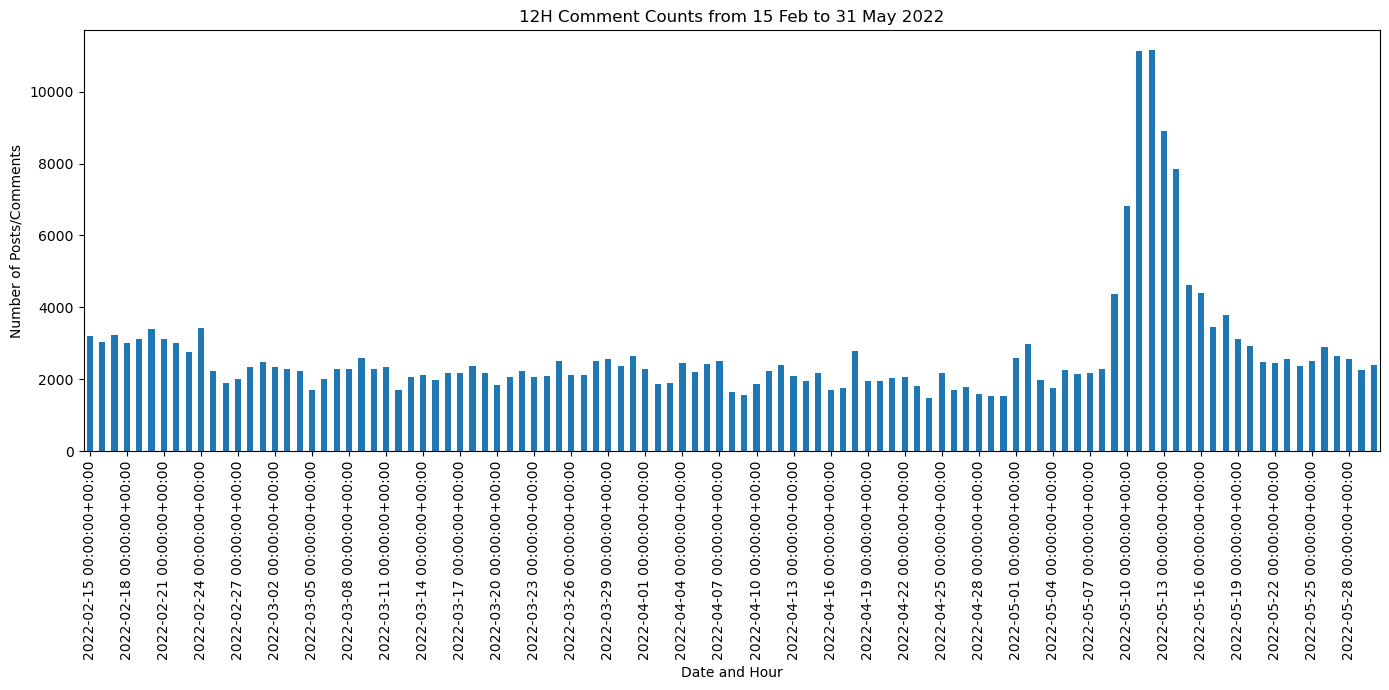

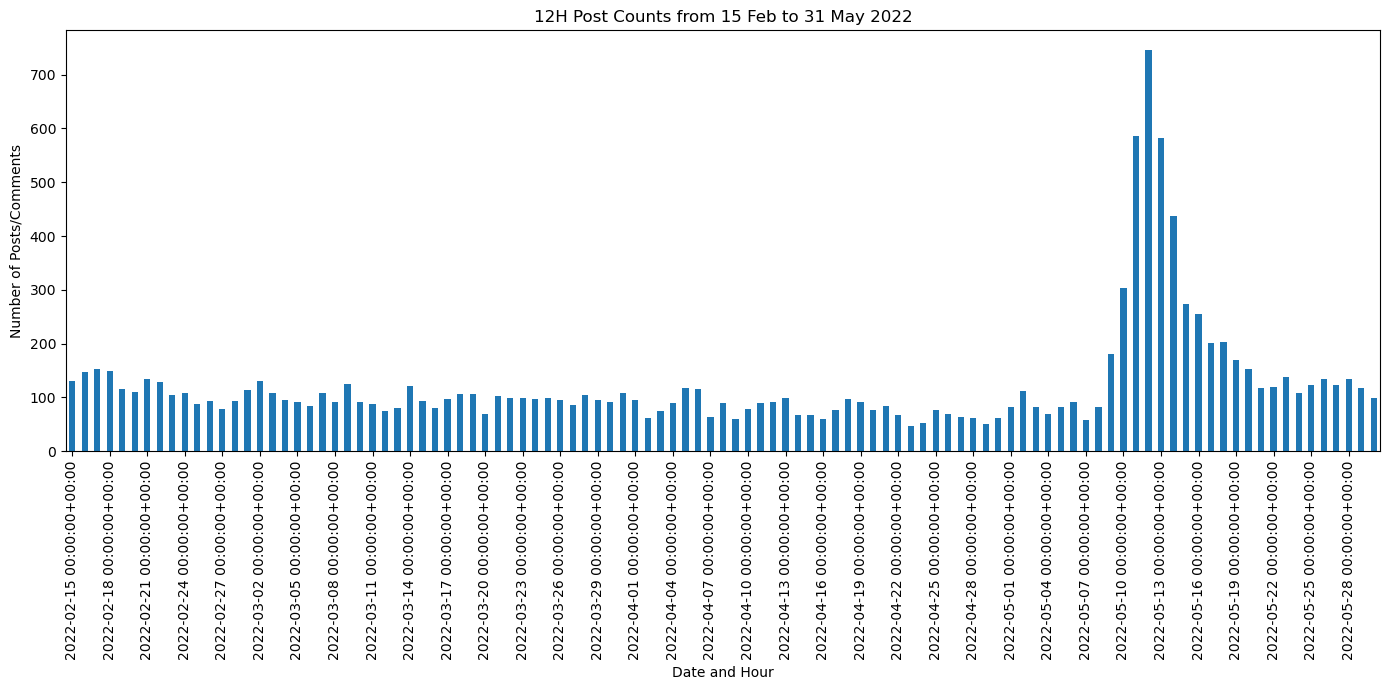

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def load_and_prepare_data(file_path):
    df = pd.read_json(file_path, lines=True)
    print(f"Data loaded, total records: {len(df)}")  # Stampa il numero di record caricati
    
    # Controlla il formato delle date mostrando alcuni esempi
    print("Sample dates from file:")
    print(df['created_utc'].head())

    # Converti i timestamp in datetime
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='ms', utc=True)  # Converti da millisecondi
    print("Sample dates after conversion to datetime:")
    print(df['created_utc'].head())

    # Filtra i dati per il range di date desiderato
    mask = (df['created_utc'] >= pd.Timestamp('2022-02-15T00:00:00Z')) & (df['created_utc'] <= pd.Timestamp('2022-05-31T23:59:59Z'))
    #mask = (df['created_utc'] >= pd.Timestamp('2022-02-15')) & (df['created_utc'] <= pd.Timestamp('2022-05-31'))
    df = df.loc[mask]
    print(f"Records after date filtering: {len(df)}")  # Stampa il numero di record dopo il filtraggio per data
    return df


def plot_data(df, title):
    if df.empty:
        print(f"No data to plot for {title}.")
        return

    # Imposta 'created_utc' come indice
    df.set_index('created_utc', inplace=True)
    # Raggruppa per ora e conta le occorrenze
    #hourly_counts = df.resample('12H').size()
    hourly_counts = df.resample('1D').size()
    
    if hourly_counts.empty:
        print(f"No hourly data to plot for {title}.")
        return

    # Crea il grafico
    plt.figure(figsize=(14, 7))
    hourly_counts.plot(kind='bar')
    plt.xlabel('Date and Hour')
    plt.ylabel('Number of Posts/Comments')
    plt.title(title)
    plt.xticks(rotation=90)  # Ruota le etichette per leggibilità
    # Mostra solo ogni terza etichetta sull'asse x per evitare sovraffollamento
    plt.gca().set_xticks(plt.gca().get_xticks()[::3])
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

if __name__ == "__main__":
    # Percorsi ai file
    comments_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_terra2.json"
    posts_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_terra2.json"

    # Carica e prepara i dati
    comments_df = load_and_prepare_data(comments_file_path)
    posts_df = load_and_prepare_data(posts_file_path)

    # Plotta i dati
    plot_data(comments_df, '12H Comment Counts from 15 Feb to 31 May 2022')
    plot_data(posts_df, '12H Post Counts from 15 Feb to 31 May 2022')


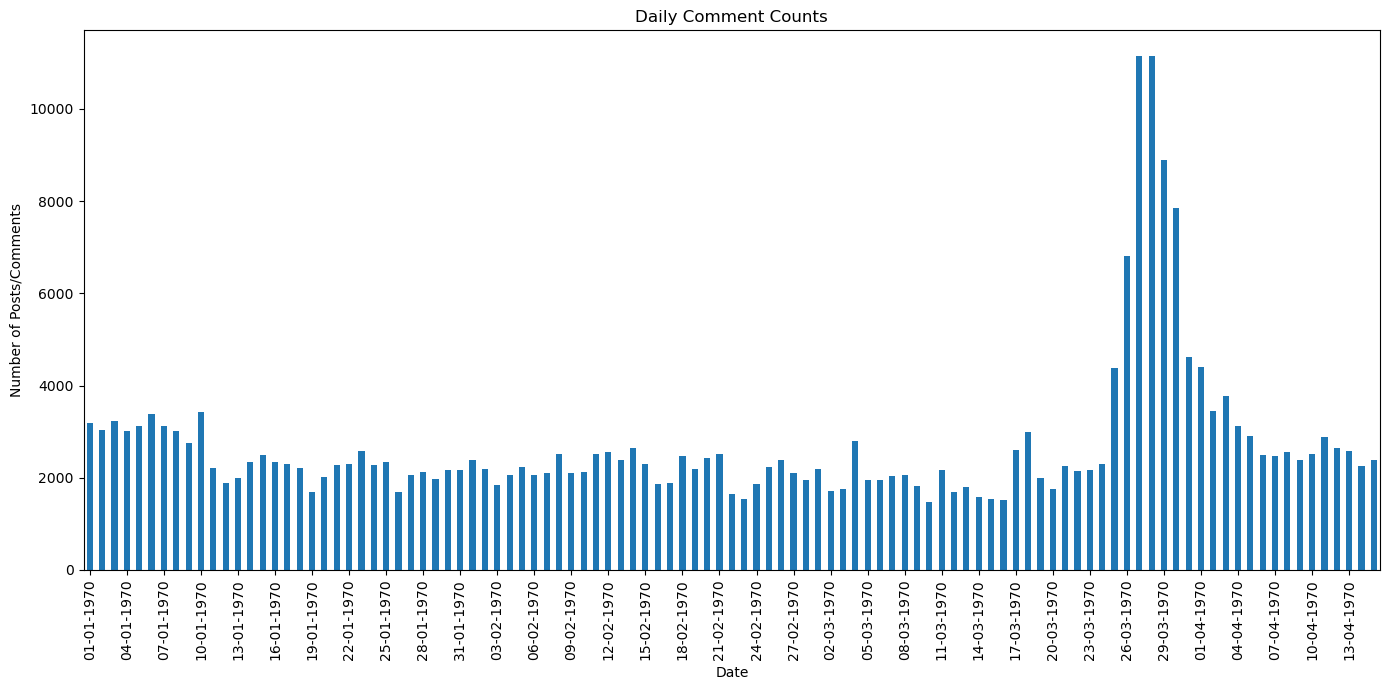

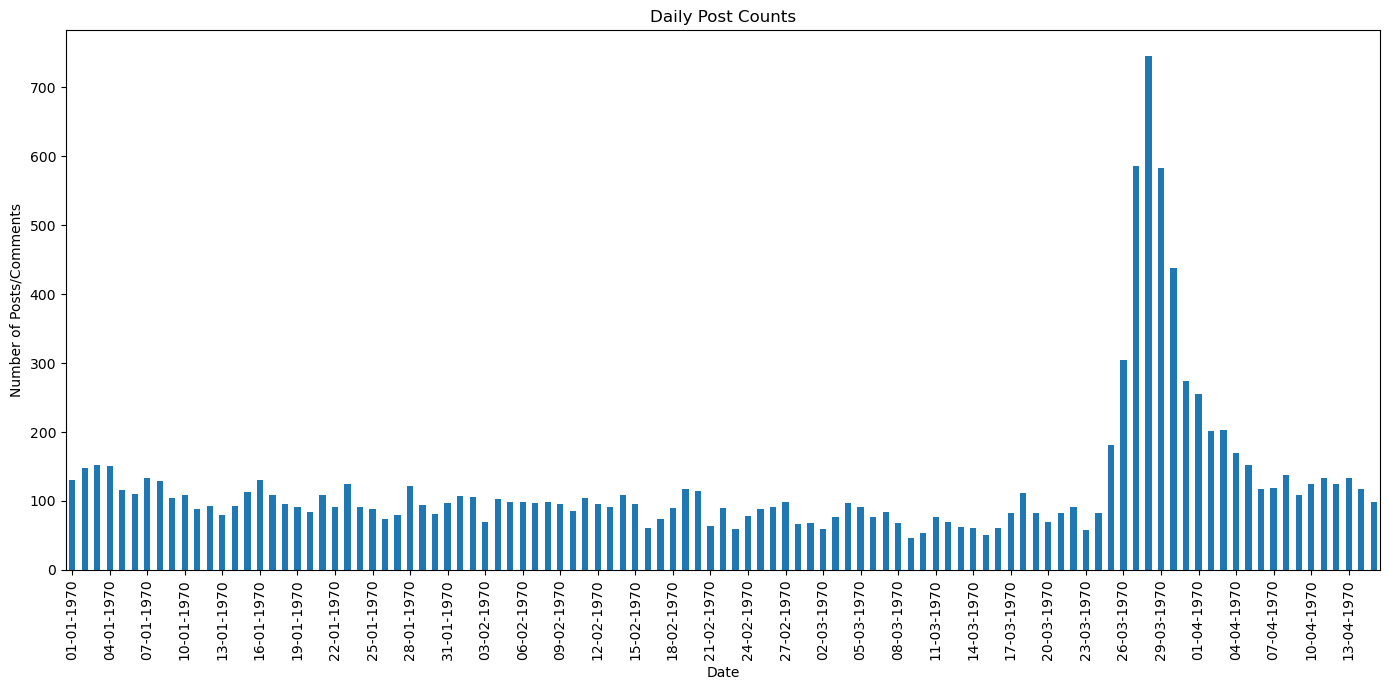

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

def load_and_prepare_data(file_path):
    df = pd.read_json(file_path, lines=True)
    # Filtra eventuali timestamp non validi prima della conversione
    df = df[df['created_utc'] > 0]  # Filtra i timestamp non validi (ad esempio, negativi)
    # Converti i timestamp in datetime
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='ms', errors='coerce')  # Converti da millisecondi
    df = df.dropna(subset=['created_utc'])  # Rimuovi i record con date non convertibili
    return df

def plot_data(df, title):
    if df.empty:
        print(f"No data to plot for {title}.")
        return

    # Imposta 'created_utc' come indice
    df.set_index('created_utc', inplace=True)
    # Raggruppa per giorno e conta le occorrenze
    daily_counts = df.resample('1D').size()
    
    if daily_counts.empty:
        print(f"No daily data to plot for {title}.")
        return

    # Crea il grafico
    plt.figure(figsize=(14, 7))
    daily_counts.plot(kind='bar')
    # Formatta le etichette dell'asse X per mostrare solo le date senza l'ora
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.xlabel('Date')
    plt.ylabel('Number of Posts/Comments')
    plt.title(title)
    plt.xticks(rotation=90)  # Ruota le etichette per leggibilità
    # Mostra solo ogni terza etichetta sull'asse x per evitare sovraffollamento
    plt.gca().set_xticks(plt.gca().get_xticks()[::3])
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Percorsi ai file
    comments_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_terra2.json"
    posts_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_terra2.json"

    # Carica e prepara i dati
    comments_df = load_and_prepare_data(comments_file_path)
    posts_df = load_and_prepare_data(posts_file_path)

    # Plotta i dati
    plot_data(comments_df, 'Daily Comment Counts')
    plot_data(posts_df, 'Daily Post Counts')

    # Salva il DataFrame combinato in un file CSV (opzionale)
    comments_df.to_csv('numeroCommTerra.csv')
    posts_df.to_csv('numeroPostTerra.csv')


# 2 - Disegnare il grafico del prezzo e sovrapporlo a quello dei post e dei commenti
### Ottenere Dati sui Prezzi da Binance e Yahoo!finance
Per ottenere i dati dei prezzi di LUNA, ho usato:

#### Binance
Per i prezzi a intervalli di 5 min dal 7 novembre 2022 al 10 novembre 2022:
1. Sono andato su questa [pagina](https://www.binance.com/it/landing/data)
2. Mi sono posizionato col mouse su *Index Price K-Line*
3. 3. Ho cliccato *USDⓢ-M*
4. Ho settato i vari parametri:
    - Simbolo: LUNAUSDT
    - Intervallo: Monthly
    - Granularità: 5m
    - Intervallo di date: 2022-04-01 -> 2022-05-31 (non 2022-02-15)
    - Dati aggiornati ogni giorno alle 00:00 (UTC+0)
5. Ho scaricato 2 file CSV (uno per ogni mese)
6. Li ho uniti in un unico file **LUNAUSDTaprileMaggio.csv**

### Binance (5 min)
| Field Name               | Description                                |
|--------------------------|--------------------------------------------|
| open_time                | Kline Open time in unix time format        |
| open                     | Index Price Open Price                     |
| high                     | Index Price High Price                     |
| low                      | Index Price Low Price                      |
| close                    | Index Price Close Price                    |
| volume                   | Ignore                                     |
| close_time               | Kline Open time in unix time format        |
| quote_volume             | Ignore                                     |
| count                    | Ignore                                     |
| taker_buy_volume         | Ignore                                     |
| taker_buy_quote_volume   | Ignore                                     |
| ignore                   | Ignore                                     |


In [5]:
import pandas as pd
import datetime

def convert_timestamp_to_readable_date(timestamp):
    try:
        # Convertire il timestamp in un oggetto datetime
        dt_object = datetime.datetime.fromtimestamp(int(timestamp) / 1000)
        # Formattare la data in un formato leggibile
        readable_date = dt_object.strftime('%H:%M:%S %d-%m-%Y')
        return readable_date
    except (ValueError, OSError):
        return None  # Gestione degli errori per timestamp non validi

# Percorso del file CSV
posts_file_path = "C:/Users/giaco/ProgettoIngInf/LUNAUSDTaprileMaggio.csv"

# Leggi il file CSV in un DataFrame
df = pd.read_csv(posts_file_path)

# Assicurati che i valori delle colonne open_time e close_time siano numeri interi
df['open_time'] = pd.to_numeric(df['open_time'], errors='coerce')
df['close_time'] = pd.to_numeric(df['close_time'], errors='coerce')

# Convertire i timestamp nelle colonne "open_time" e "close_time" in date leggibili
df['open_time'] = df['open_time'].apply(convert_timestamp_to_readable_date)
df['close_time'] = df['close_time'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop = ['volume', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
df.drop(columns=columns_to_drop, inplace=True)

# Visualizzare le prime righe del DataFrame risultante
# print(df.head())
print(df[['open_time', 'open']])


                 open_time        open
0      02:00:00 01-04-2022  103.004369
1      02:05:00 01-04-2022  103.101762
2      02:10:00 01-04-2022  103.338901
3      02:15:00 01-04-2022  103.490563
4      02:20:00 01-04-2022  103.324763
...                    ...         ...
17563  01:35:00 01-06-2022    0.000050
17564  01:40:00 01-06-2022    0.000050
17565  01:45:00 01-06-2022    0.000050
17566  01:50:00 01-06-2022    0.000050
17567  01:55:00 01-06-2022    0.000050

[17568 rows x 2 columns]


Ora prendo il df e plotto il grafico del prezzo
### Grafico del prezzo di LUNA (5 min)

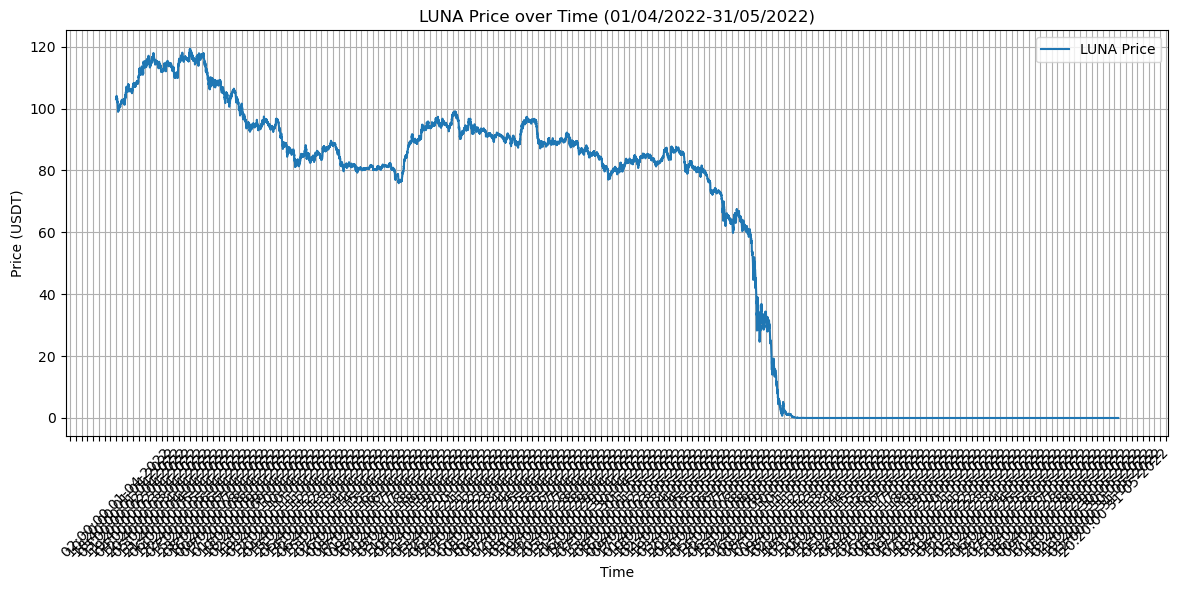

In [6]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assumi che df sia il DataFrame già caricato e con i timestamp convertiti correttamente

# Seleziona solo le colonne "open_time" e "open" per il grafico
df_filtered = df[['open_time', 'open']]

# Imposta il grafico
fig, ax = plt.subplots(figsize=(12, 6))

# Plotta il grafico del prezzo
ax.plot(df_filtered['open_time'], df_filtered['open'], label='LUNA Price')

# Imposta etichette e titolo
ax.set_xlabel('Time')
ax.set_ylabel('Price (USDT)')
ax.set_title('LUNA Price over Time (01/04/2022-31/05/2022)')
ax.legend()

# Imposta formattazione dell'asse x per visualizzare solo un dato ogni 100
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=100))

# Imposta la rotazione delle etichette dell'asse x
plt.xticks(rotation=45)

# Imposta il layout e mostra la griglia
plt.tight_layout()
ax.grid()

# Mostra il grafico
plt.show()

### Grafico numero post - prezzo FTT
Prendere il grafico del numero di post e plottarlo insieme al grafico del prezzo.

Prendo il df del numero di post e prendo le date 2022/11/5 1:00 - 2022/11/11 1:00 :

In [7]:
import pandas as pd
import datetime

def convert_timestamp_to_readable_date(timestamp):
    try:
        # Convertire il timestamp in un oggetto datetime
        dt_object = datetime.datetime.fromtimestamp(int(timestamp) / 1000)
        # Formattare la data in un formato leggibile
        # readable_date = dt_object.strftime('%H:%M:%S %d-%m-%Y')
        # return readable_date
        return dt_object
    except (ValueError, OSError):
        return None  # Gestione degli errori per timestamp non validi

# Percorso del file CSV
price_path = "C:/Users/giaco/ProgettoIngInf/LUNAUSDTaprileMaggio.csv"

# Leggi il file CSV in un DataFrame
df_price_nov = pd.read_csv(price_path)

# Assicurati che i valori delle colonne open_time e close_time siano numeri interi
df_price_nov['open_time'] = pd.to_numeric(df_price_nov['open_time'], errors='coerce')
df_price_nov['close_time'] = pd.to_numeric(df_price_nov['close_time'], errors='coerce')

# Convertire i timestamp nelle colonne "open_time" e "close_time" in date leggibili
df_price_nov['open_time'] = df_price_nov['open_time'].apply(convert_timestamp_to_readable_date)
df_price_nov['close_time'] = df_price_nov['close_time'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop = ['volume', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
df_price_nov.drop(columns=columns_to_drop, inplace=True)

# Visualizzare le prime righe del DataFrame risultante
# print(df.head())
print(df_price_nov[['open_time', 'open']])


                open_time        open
0     2022-04-01 02:00:00  103.004369
1     2022-04-01 02:05:00  103.101762
2     2022-04-01 02:10:00  103.338901
3     2022-04-01 02:15:00  103.490563
4     2022-04-01 02:20:00  103.324763
...                   ...         ...
17563 2022-06-01 01:35:00    0.000050
17564 2022-06-01 01:40:00    0.000050
17565 2022-06-01 01:45:00    0.000050
17566 2022-06-01 01:50:00    0.000050
17567 2022-06-01 01:55:00    0.000050

[17568 rows x 2 columns]


Tengo solo i dati del prezzo nell'intervallo di date 2022/04/18 1:00 - 2022/05/15 1:00 :

In [8]:
# Definisci le date di inizio e fine
start_date = datetime.datetime(2022, 4, 18, 1, 0, 0)
end_date = datetime.datetime(2022, 5, 18, 1, 0, 0)

# Filtra i dati
df_price_nov_filtered = df_price_nov[(df_price_nov['open_time'] >= start_date) & (df_price_nov['open_time'] <= end_date)]

# Visualizza le prime righe del DataFrame filtrato
print(df_price_nov_filtered[['open_time', 'open']])

                open_time       open
4884  2022-04-18 01:00:00  79.891516
4885  2022-04-18 01:05:00  79.265514
4886  2022-04-18 01:10:00  79.177994
4887  2022-04-18 01:15:00  79.333840
4888  2022-04-18 01:20:00  79.293214
...                   ...        ...
13520 2022-05-18 00:40:00   0.000050
13521 2022-05-18 00:45:00   0.000050
13522 2022-05-18 00:50:00   0.000050
13523 2022-05-18 00:55:00   0.000050
13524 2022-05-18 01:00:00   0.000050

[8641 rows x 2 columns]


Prendo i dati dei post dal file json e tengo solo le date che mi interessano e sommo il numero di post a intervalli di 30 min:

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Carica i dati dal file JSON
json_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_terra2.json"
df_json = pd.read_json(json_file_path, lines=True)

# Converte 'created_utc' in datetime e filtra per il range di date
df_json['created_utc'] = pd.to_datetime(df_json['created_utc'], unit='ms')
start_date = datetime(2022, 4, 18, 1, 0, 0)
end_date = datetime(2022, 5, 18, 1, 0, 0)
df_json_filtered = df_json[(df_json['created_utc'] >= start_date) & (df_json['created_utc'] <= end_date)]

# Raggruppa i dati ogni 30 minuti
df_json_filtered.set_index('created_utc', inplace=True)
df_counts = df_json_filtered.resample('1H').size()


Preparo il grafico del numero di post:

(array([19099., 19103., 19107., 19111., 19113., 19117., 19121., 19125.,
        19129.]),
 [Text(19099.0, 0, '2022-04-17'),
  Text(19103.0, 0, '2022-04-21'),
  Text(19107.0, 0, '2022-04-25'),
  Text(19111.0, 0, '2022-04-29'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19117.0, 0, '2022-05-05'),
  Text(19121.0, 0, '2022-05-09'),
  Text(19125.0, 0, '2022-05-13'),
  Text(19129.0, 0, '2022-05-17')])

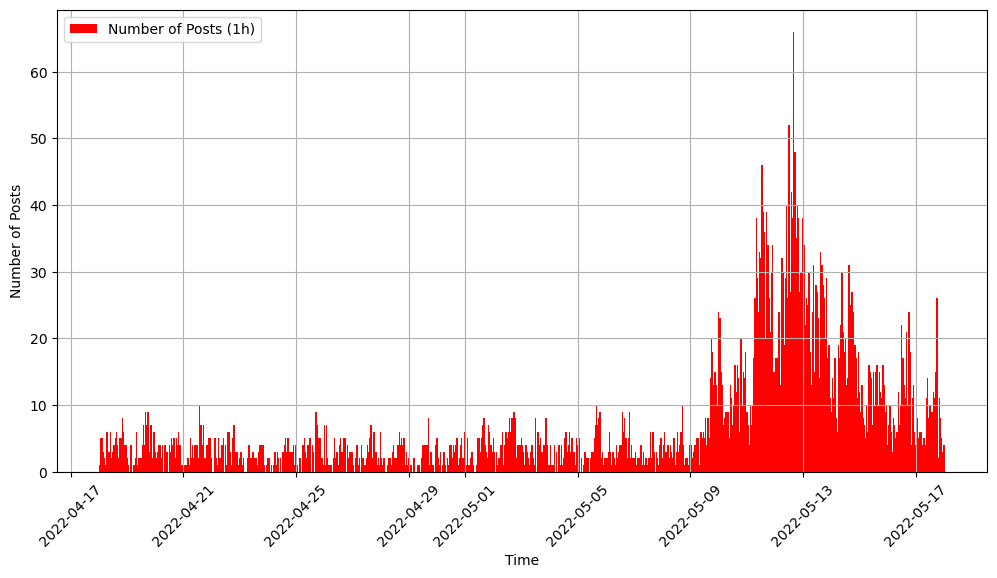

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(df_counts.index, df_counts, width=0.05, label='Number of Posts (1h)', color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)


Combino i due grafici:

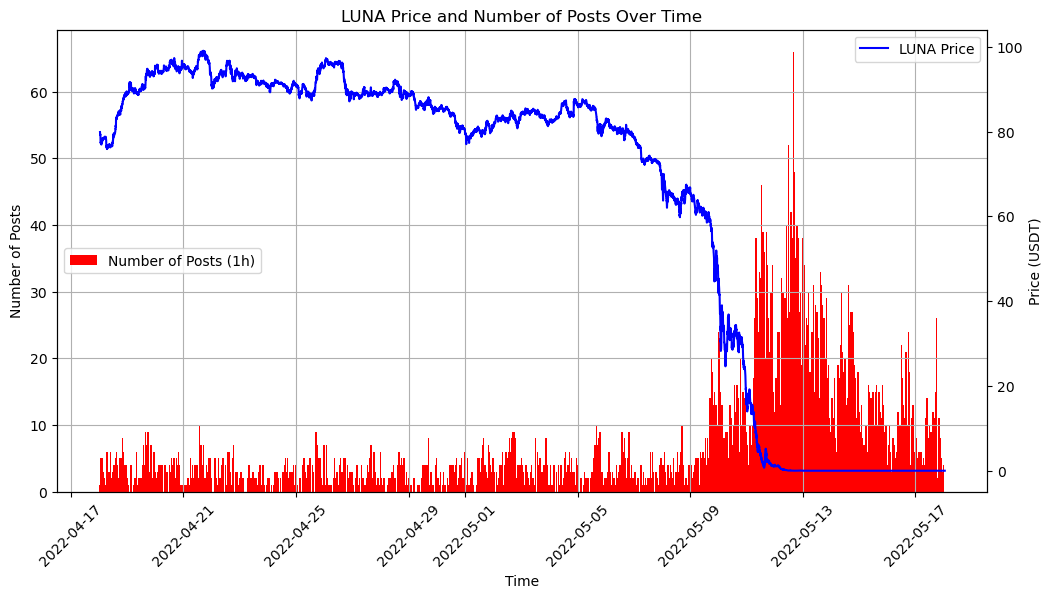

In [11]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts.index, df_counts, width=0.05, label='Number of Posts (1h)', color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts')
ax1.legend(loc='center left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='LUNA Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('LUNA Price and Number of Posts Over Time')
plt.show()

## Grafico post + commenti + prezzo

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Carica i dati dal file JSON
json_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_terra2.json"
df_json_com = pd.read_json(json_file_path, lines=True)

# Converte 'created_utc' in datetime e filtra per il range di date
df_json_com['created_utc'] = pd.to_datetime(df_json_com['created_utc'], unit='ms')
start_date = datetime(2022, 4, 18, 1, 0, 0)
end_date = datetime(2022, 5, 18, 1, 0, 0)
df_json__com_filtered = df_json_com[(df_json_com['created_utc'] >= start_date) & (df_json_com['created_utc'] <= end_date)]

# Raggruppa i dati ogni 30 minuti
df_json__com_filtered.set_index('created_utc', inplace=True)
df_counts_com = df_json__com_filtered.resample('30T').size()


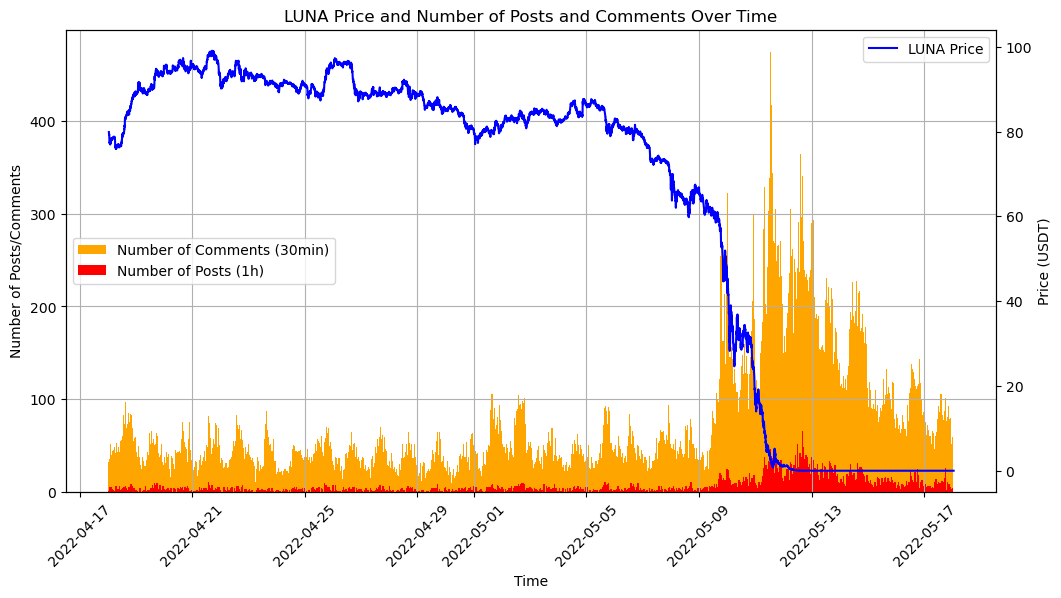

In [13]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di commenti ogni 30 minuti
ax1.bar(df_counts_com.index, df_counts_com, width=0.03, label='Number of Comments (30min)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='center left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta l'istogramma del numero di post ogni ora
ax1.bar(df_counts.index, df_counts, width=0.05, label='Number of Posts (1h)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='center left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di LUNA
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='LUNA Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('LUNA Price and Number of Posts and Comments Over Time')
plt.show()

# Lista dei vari data frame disponibili
* **df_counts_com** : numero di **commenti** ogni 30 minuti
* **df_counts** : numero di **post** ogni 30 minuti
* **df_price_nov_filtered** : **prezzo** di ftt a granularità 5 minuti

Tutti i dati sono nel periodo (2022/11/5 1:00 - 2022/11/11 1:00)

# 4 - Aggiungere PyTrends al grafico

Ho scaricato i file csv direttamente da **Google Trends** perché pytrends contunuava a darmi errore 429

In [14]:
# Comparare il numero di ricerche di FTX con quello dell'argomento "matita" (pencil)

# Grafico nel tempo
timeline_path_2 = "C:/Users/giaco/ProgettoIngInf/multiTimelineTerra3_modified.csv"
timeline_path = "C:/Users/giaco/ProgettoIngInf/multiTimelineTerraMatita.csv"

df_trend_time = pd.read_csv(timeline_path)
df_trend_time_2 = pd.read_csv(timeline_path_2)


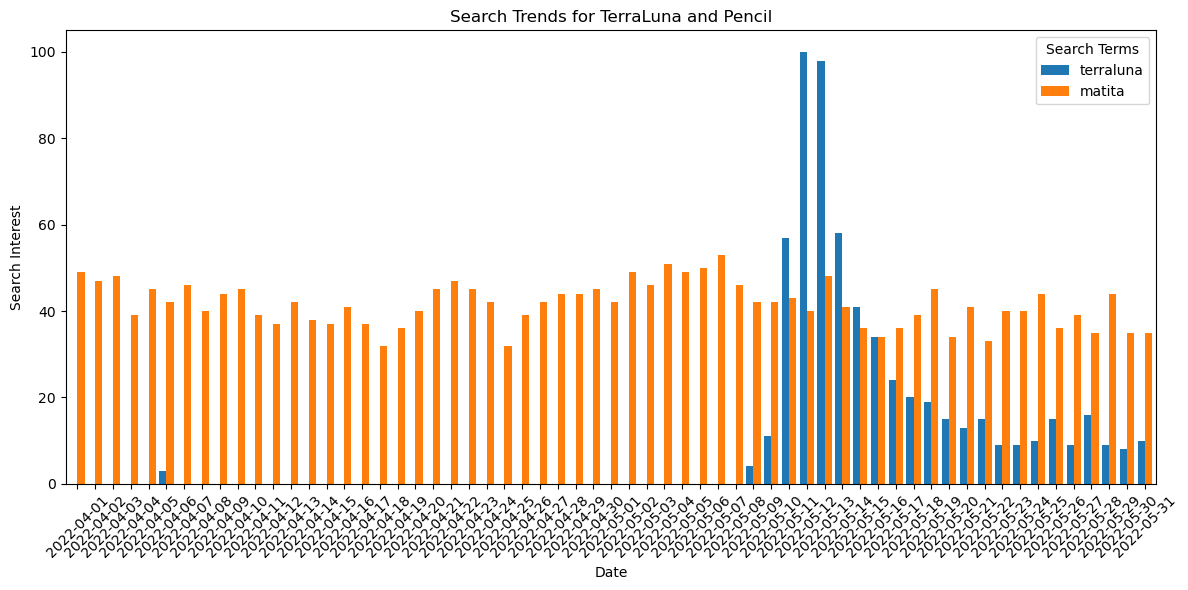

In [15]:
# Convert the 'Giorno' column to datetime
df_trend_time['Giorno'] = pd.to_datetime(df_trend_time['Giorno'])

# Set the 'Tempo' column as the index
df_trend_time.set_index('Giorno', inplace=True)

# Plot the data as a bar chart with two columns for each date
ax = df_trend_time.plot(kind='bar', figsize=(12, 6), width=0.8)

# Format x-axis to show only dates
ax.set_xticklabels(df_trend_time.index.strftime('%Y-%m-%d'))

# Set the title and labels
plt.title('Search Trends for TerraLuna and Pencil')
plt.xlabel('Date')
plt.ylabel('Search Interest')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
plt.legend(title='Search Terms')

# Show the plot
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

# Controlla le colonne del DataFrame
print("Colonne del DataFrame:", df_trend_time_2.columns)

# Controlla se ci sono spazi bianchi nei nomi delle colonne
df_trend_time_2.columns = df_trend_time_2.columns.str.strip()

# Stampa le prime righe del DataFrame
print(df_trend_time_2.head())

# Assicurati che la colonna 'Tempo' sia presente e corretta
if 'Giorno' in df_trend_time_2.columns:
    # Converti la colonna 'Giorno' in un formato datetime
    df_trend_time_2['Giorno'] = pd.to_datetime(df_trend_time_2['Giorno'], format='%Y-%m-%d')
    #start_date = datetime(2022, 4, 18, 1, 0, 0)
    #end_date = datetime(2022, 5, 18, 1, 0, 0)
    start_date = datetime(2022, 4, 18)
    end_date = datetime(2022, 5, 18)
    df_trend_time_2 = df_trend_time_2[(df_trend_time_2['Giorno'] >= start_date) & (df_trend_time_2['Giorno'] <= end_date)]
    # Setta la colonna 'Tempo' come indice
    df_trend_time_2.set_index('Giorno', inplace=True)
    print("Conversione e impostazione dell'indice riuscite.")
else:
    print("La colonna 'Tempo' non esiste nel DataFrame.")


Colonne del DataFrame: Index(['Tempo', 'terra'], dtype='object')
           Tempo  terra
0  2022-05-05T02      0
1  2022-05-05T03      0
2  2022-05-05T04      0
3  2022-05-05T05      0
4  2022-05-05T06      0
La colonna 'Tempo' non esiste nel DataFrame.


In [36]:
import pandas as pd

# Carica il file CSV
file_path = 'trendsTerra_2.csv'
df = pd.read_csv(file_path)

# Funzione per convertire le date al formato datetime, gestendo formati misti
def convert_to_datetime(date_str):
    try:
        return pd.to_datetime(date_str, format='%Y-%m-%dT%H', errors='coerce')
    except ValueError:
        return pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce')

# Converti la colonna della data utilizzando la funzione definita
df['date'] = df['date'].apply(convert_to_datetime)

# Funzione per espandere i valori giornalieri a valori ogni 3 ore
def expand_daily_to_three_hourly(df):
    three_hourly_data = []
    for index, row in df.iterrows():
        if pd.isnull(row['date']):
            continue
        if row['date'].hour == 0 and row['date'].minute == 0:
            # Se il timestamp è giornaliero, crea 8 righe di 3 ore con lo stesso valore
            for hour in range(0, 24, 8):
                three_hourly_data.append([row['date'] + pd.Timedelta(hours=hour), row['TerraLUNA']])
        else:
            # Se il timestamp è già ogni 3 ore, aggiungi la riga così com'è
            three_hourly_data.append([row['date'], row['TerraLUNA']])
    
    return pd.DataFrame(three_hourly_data, columns=['date', 'TerraLUNA'])

# Applica la funzione per espandere i valori giornalieri a valori ogni 3 ore
df_three_hourly = expand_daily_to_three_hourly(df)

# Ordina il DataFrame risultante per data
df_three_hourly.sort_values(by='date', inplace=True)

# Salva il DataFrame modificato in un nuovo file CSV
output_path = 'trendsTerra_2_three_hourly.csv'
df_three_hourly.to_csv(output_path, index=False)

print(f"Data converted to three-hourly granularity saved to '{output_path}'")


Data converted to three-hourly granularity saved to 'trendsTerra_2_three_hourly.csv'


In [41]:
import pandas as pd

# Carica il file CSV
file_path = 'trendsTerra_2_hourly.csv'
df = pd.read_csv(file_path)

# Mantieni una riga ogni 5
df_reduced = df.iloc[::3]

# Salva il DataFrame ridotto in un nuovo file CSV
output_path_reduced = 'trendsTerra_2_hourly_reduced.csv'
df_reduced.to_csv(output_path_reduced, index=False)

print(f"Data reduced to every 5th row saved to '{output_path_reduced}'")


Data reduced to every 5th row saved to 'trendsTerra_2_hourly_reduced.csv'


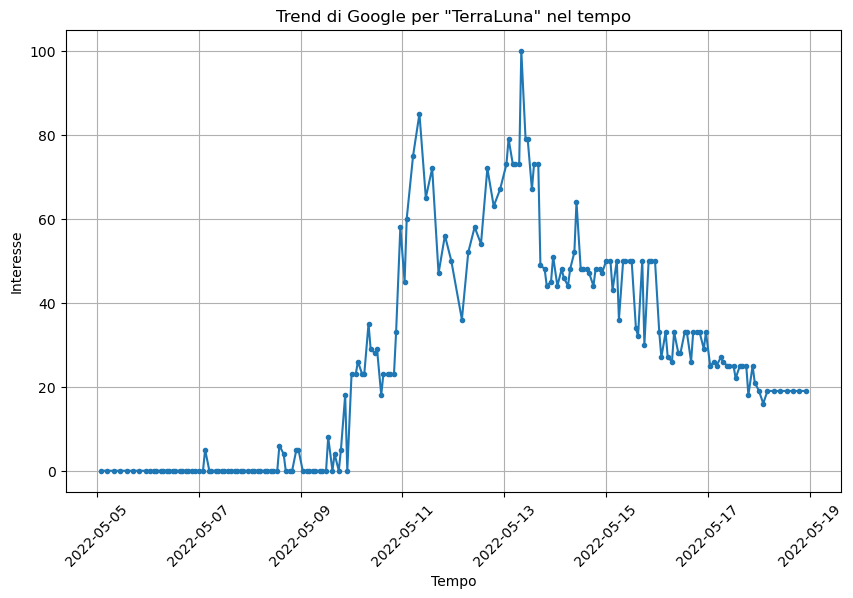

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

timeline_path_2 = "C:/Users/giaco/ProgettoIngInf/trendsTerra_2_hourly_reduced.csv"

df_trend_time_2 = pd.read_csv(timeline_path_2)
# Convert the 'Giorno' column to datetime
df_trend_time_2['date'] = pd.to_datetime(df_trend_time_2['date'])

# Set the 'Tempo' column as the index
df_trend_time_2.set_index('date', inplace=True)
# Esempio di grafico utilizzando la colonna 'Tempo' come indice
plt.figure(figsize=(10, 6))
plt.plot(df_trend_time_2.index, df_trend_time_2['TerraLUNA'], marker='.', linestyle='-')
plt.title('Trend di Google per "TerraLuna" nel tempo')
plt.xlabel('Tempo')
plt.ylabel('Interesse')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


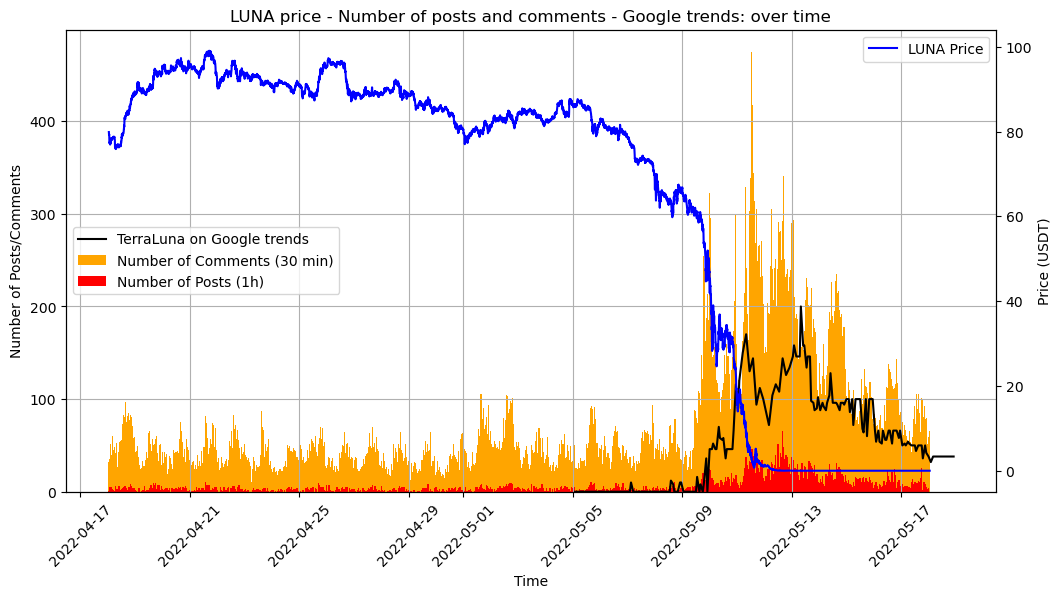

In [48]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di commenti ogni 30 minuti
ax1.bar(df_counts_com.index, df_counts_com, width=0.03, label='Number of Comments (30 min)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts.index, df_counts, width=0.05, label='Number of Posts (1h)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='LUNA Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Plotta i dati
# Convert the 'Tempo' column to datetime

ax1.plot(df_trend_time_2.index, df_trend_time_2['TerraLUNA']*2, label='TerraLuna on Google trends', color='black')
# se voglio che trend occupi tutta l'asse y posso fare df_trend_time['FTX']*2
# Position the legend to the left at mid height
ax1.legend(loc='center left')# , bbox_to_anchor=(1, 0.5))

# Mostra il grafico combinato
plt.title('LUNA price - Number of posts and comments - Google trends: over time')
plt.show()

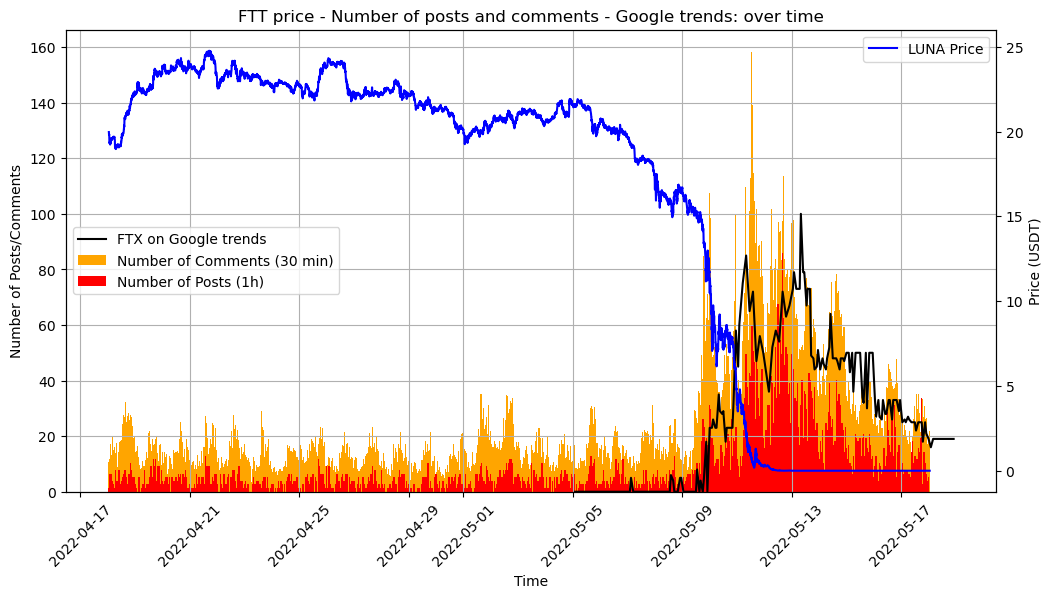

In [47]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di commenti ogni 30 minuti
ax1.bar(df_counts_com.index, df_counts_com/3, width=0.03, label='Number of Comments (30 min)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts.index, df_counts*1.3, width=0.05, label='Number of Posts (1h)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open']/4, label='LUNA Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Plotta i dati
# Convert the 'Tempo' column to datetime

ax1.plot(df_trend_time_2.index, df_trend_time_2['TerraLUNA'], label='FTX on Google trends', color='black')
# se voglio che trend occupi tutta l'asse y posso fare df_trend_time['FTX']*2
# Position the legend to the left at mid height
ax1.legend(loc='center left')# , bbox_to_anchor=(1, 0.5))

# Mostra il grafico combinato
plt.title('FTT price - Number of posts and comments - Google trends: over time')
plt.show()

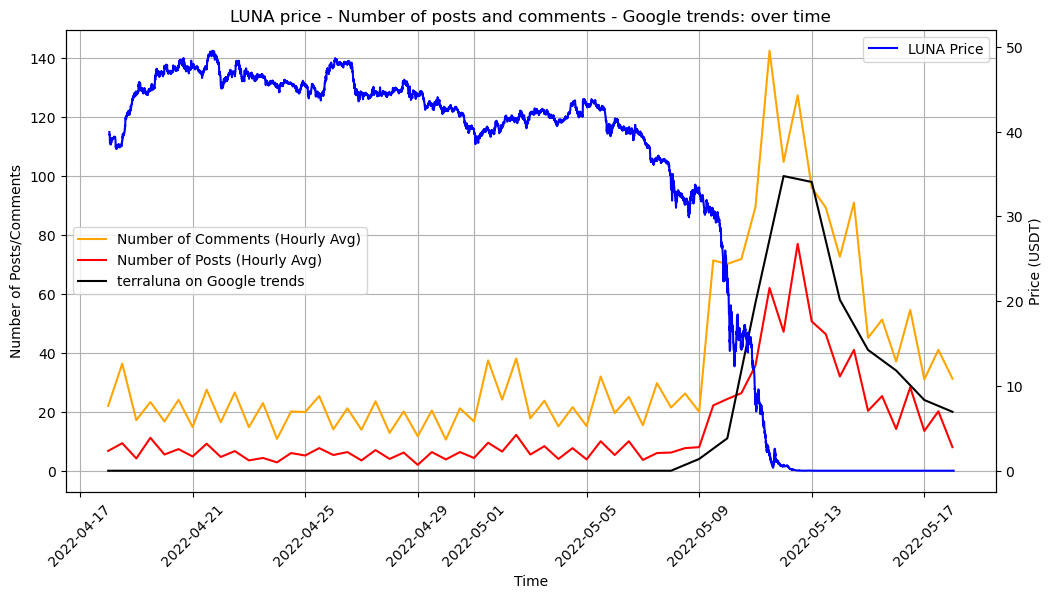

In [96]:
# Raggruppa i dati ogni 60 minuti (1 ora) e calcola la media
df_counts_hourly = df_counts.resample('12H').mean()
df_counts_com_hourly = df_counts_com.resample('12H').mean()

# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta il grafico del numero di commenti ogni 30 minuti mediati su un'ora
ax1.plot(df_counts_com_hourly.index, df_counts_com_hourly / 2, label='Number of Comments (Hourly Avg)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del numero di post ogni 30 minuti mediati su un'ora
ax1.plot(df_counts_hourly.index, df_counts_hourly * 2, label='Number of Posts (Hourly Avg)', color='red')
ax1.set_xlabel('Time')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='LUNA Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Plotta i dati di Google Trends
ax1.plot(df_trend_time_2.index, df_trend_time_2['terraluna'], label='terraluna on Google trends', color='black')
ax1.legend(loc='center left')

# Mostra il grafico combinato
plt.title('LUNA price - Number of posts and comments - Google trends: over time')
plt.show()


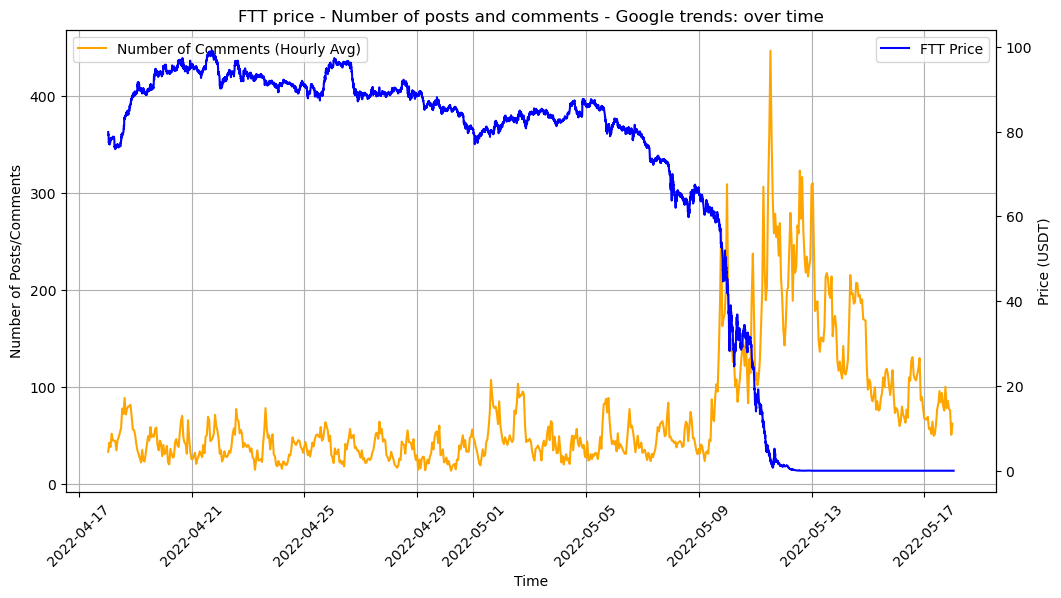

In [97]:
# Raggruppa i dati ogni 60 minuti (1 ora) e calcola la media
df_counts_hourly = df_counts.resample('1H').mean()
df_counts_com_hourly = df_counts_com.resample('1H').mean()

# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta il grafico del numero di commenti ogni 30 minuti mediati su un'ora
ax1.plot(df_counts_com_hourly.index, df_counts_com_hourly, label='Number of Comments (Hourly Avg)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts/Comments')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='FTT Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('FTT price - Number of posts and comments - Google trends: over time')
plt.show()


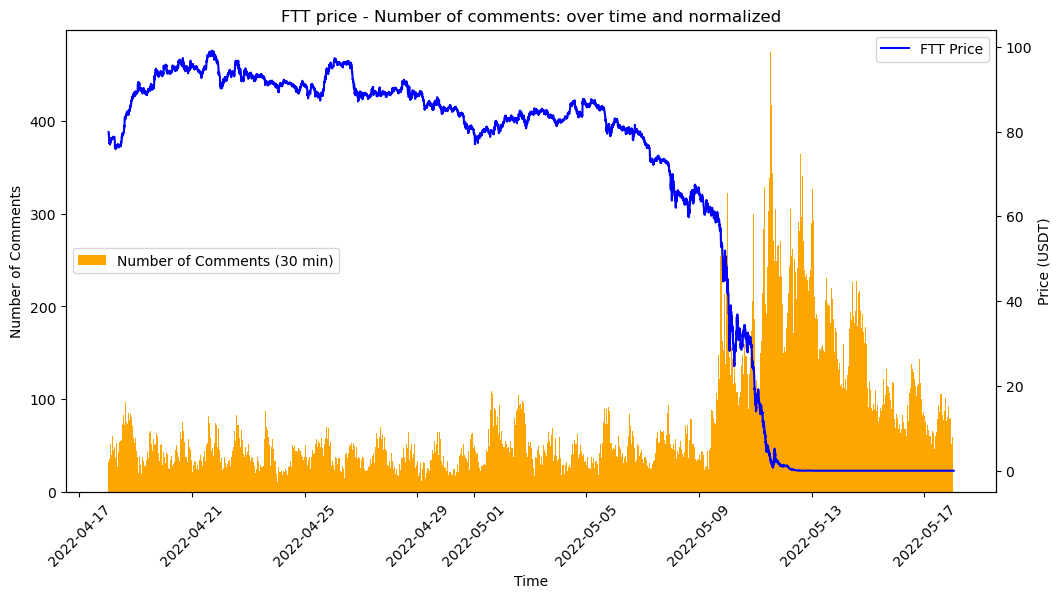

In [110]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di commenti ogni 30 minuti
ax1.bar(df_counts_com.index, df_counts_com, width=0.03, label='Number of Comments (30 min)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Comments')
ax1.legend(loc='center left')
#ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] , label='FTT Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('FTT price - Number of comments: over time and normalized')
plt.show()


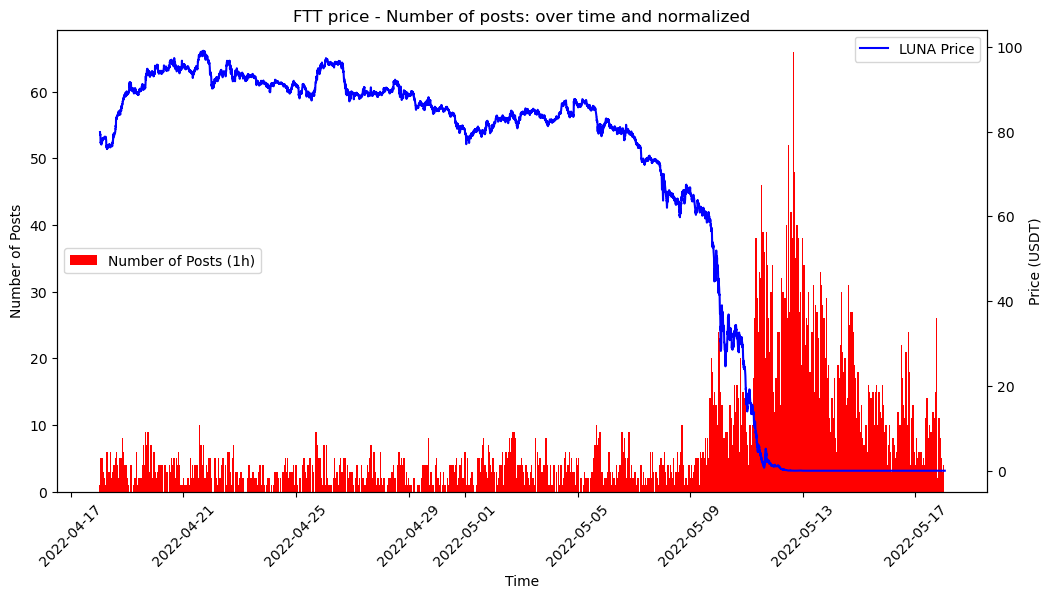

In [106]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts.index, df_counts, width=0.05, label='Number of Posts (1h)', color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts')
ax1.legend(loc='center left')
#ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'], label='LUNA Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('FTT price - Number of posts: over time and normalized')
plt.show()


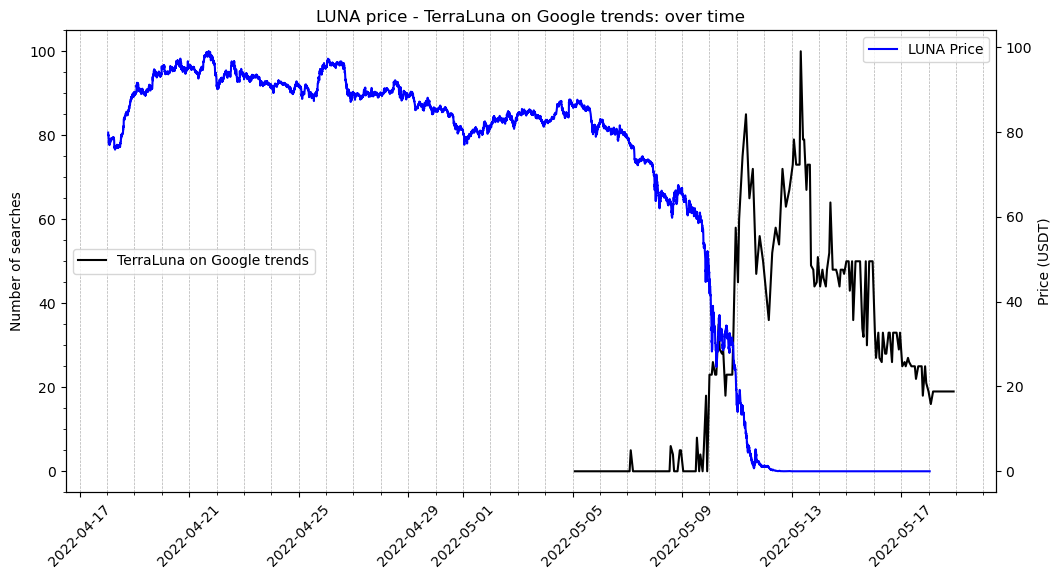

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

timeline_path_2 = "C:/Users/giaco/ProgettoIngInf/trendsTerra_2_hourly_reduced.csv"

df_trend_time_2 = pd.read_csv(timeline_path_2)
# Convert the 'Giorno' column to datetime
df_trend_time_2['date'] = pd.to_datetime(df_trend_time_2['date'])

# Convert the 'Giorno' column to datetime
#df_trend_time_2['date'] = pd.to_datetime(df_trend_time_2['date'])

# Set the 'Tempo' column as the index
df_trend_time_2.set_index('date', inplace=True)

# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Aggiungi una griglia fitta verticale
plt.grid(which='both', axis='x', linestyle='--', linewidth=0.5)
plt.minorticks_on()  # Abilita i tick minori

ax1.plot(df_trend_time_2.index, df_trend_time_2['TerraLUNA'], label='TerraLuna on Google trends', color='black')
# se voglio che trend occupi tutta l'asse y posso fare df_trend_time['FTX']*2
# Position the legend to the left at mid height
#ax1.grid(True)
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
ax1.set_ylabel('Number of searches')
ax1.legend(loc='center left')# , bbox_to_anchor=(1, 0.5))

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] , label='LUNA Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='best')


# Mostra il grafico combinato
plt.title('LUNA price - TerraLuna on Google trends: over time')
plt.show()


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Carica i dati dal file JSON
com_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_terra2.json"
df_json_com = pd.read_json(com_file_path, lines=True)
# Carica i dati dal file JSON
post_file_path = "C:/Users/giaco/ProgettoIngInf/filtered_post_terra2.json"
df_json_post = pd.read_json(post_file_path, lines=True)

start_date = datetime(2022, 4, 18, 1, 0, 0)
end_date = datetime(2022, 5, 18, 1, 0, 0)
# Converte 'created_utc' in datetime e filtra per il range di date
df_json_com['created_utc'] = pd.to_datetime(df_json_com['created_utc'], unit='ms')
df_json_com_filtered = df_json_com[(df_json_com['created_utc'] >= start_date) & (df_json_com['created_utc'] <= end_date)]
# Converte 'created_utc' in datetime e filtra per il range di date
df_json_post['created_utc'] = pd.to_datetime(df_json_post['created_utc'], unit='ms')
df_json_post_filtered = df_json_post[(df_json_post['created_utc'] >= start_date) & (df_json_post['created_utc'] <= end_date)]

# Raggruppa i dati ogni 30 minuti
df_json_com_filtered.set_index('created_utc', inplace=True)
df_counts_com = df_json_com_filtered.resample('2H').size()
# Raggruppa i dati ogni 30 minuti
df_json_post_filtered.set_index('created_utc', inplace=True)
df_counts_post = df_json_post_filtered.resample('2H').size()

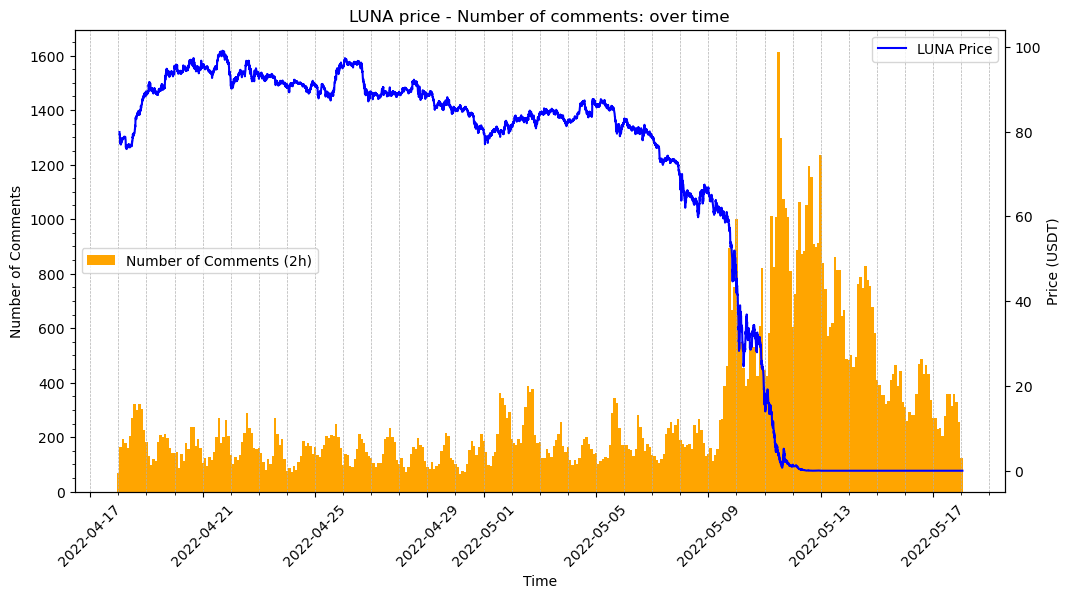

In [6]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Aggiungi una griglia fitta verticale
plt.grid(which='both', axis='x', linestyle='--', linewidth=0.5)
plt.minorticks_on()  # Abilita i tick minori

# Plotta l'istogramma del numero di commenti ogni 30 minuti
ax1.bar(df_counts_com.index, df_counts_com, width=0.09, label='Number of Comments (2h)', color='orange')
#ax1.bar(df_counts_com.index, df_counts_com/9, width=0.1, label='Number of Comments (3h)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Comments')
ax1.legend(loc='center left')
#ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] , label='LUNA Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('LUNA price - Number of comments: over time')
plt.show()

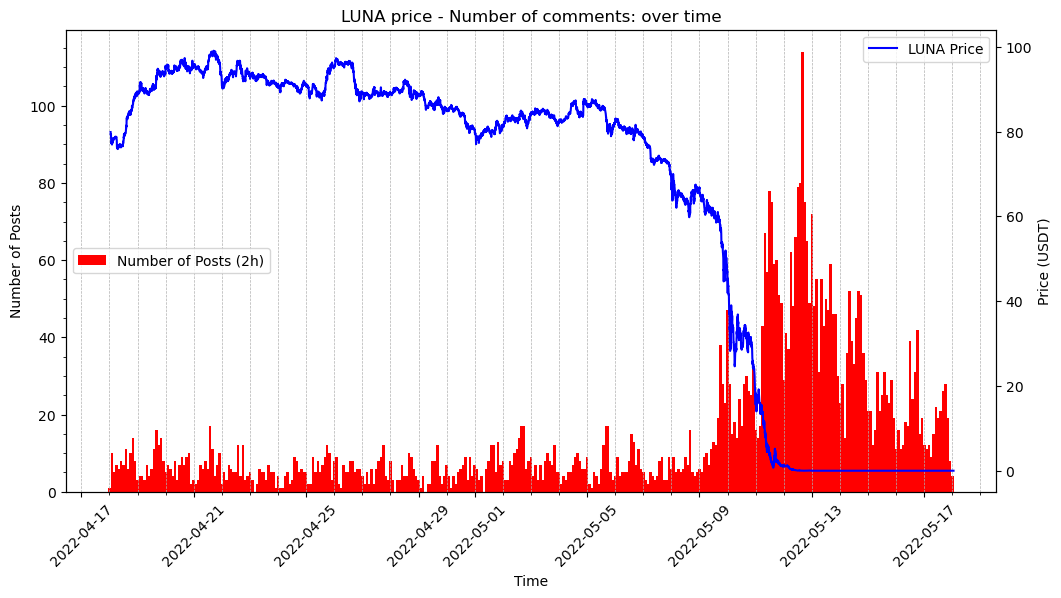

In [12]:
# Crea il grafico combinato
fig, ax1 = plt.subplots(figsize=(12, 6))

# Aggiungi una griglia fitta verticale
plt.grid(which='both', axis='x', linestyle='--', linewidth=0.5)
plt.minorticks_on()  # Abilita i tick minori

# Plotta l'istogramma del numero di post ogni 30 minuti
ax1.bar(df_counts_post.index, df_counts_post, width=0.09, label='Number of Posts (2h)', color='red')
#ax1.bar(df_counts_post.index, df_counts_post/1.362, width=0.1, label='Number of Posts (3h)', color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Posts')
ax1.legend(loc='center left')
#ax1.grid(True)
plt.xticks(rotation=45)

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov_filtered['open_time'], df_price_nov_filtered['open'] , label='LUNA Price', color='blue')
ax2.set_ylabel('Price (USDT)')
ax2.legend(loc='upper right')

# Mostra il grafico combinato
plt.title('LUNA price - Number of comments: over time')
plt.show()

<h1 style="text-align: center;">Analisi del sentiment</h1>

# 5 - Unire i commenti e i post tramite l'id
Creo due tabelle:
1. Il post con il suo id, l'autore e lo score
2. I commenti con id del post, data e ora

Da queste due tabelle ne creo una terza con id del post, numero commenti, score, e poi con (da vedere) ad esempio tre colonne con tre valori di tempo, e per ogni valore indico il numero di commenti che sono stati fatti sotto a quel determinato post entro un certo periodo di tempo.


## Tabella 1

#### Passo 1: Caricare i dati da JSON
Carica i dati dei post e dei commenti in due DataFrame pandas separati...

In [2]:
import pandas as pd
import datetime

# Carica i dati dei post
df_posts = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_post_terra2.json", lines=True)
# Carica i dati dei commenti
df_comments = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_terra2.json", lines=True)

#### Passo 2: Preparare le tabelle
Estrai le informazioni rilevanti dai DataFrame e prepara le due tabelle iniziali come specificato.

In [3]:
# Assicurati che i campi 'created_utc' siano convertiti correttamente da millisecondi a secondi
df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'], unit='ms')
df_posts['created_utc'] = pd.to_datetime(df_posts['created_utc'], unit='ms')

In [4]:
# Prepara le tabelle dei post e dei commenti
posts_table = df_posts[['id', 'author', 'score', 'num_comments', 'created_utc']]
comments_table = df_comments[['link_id', 'created_utc']]

#### Passo 3: Creare una tabella combinata
Unisci i commenti e i post tramiteidDe link_id (llink_id nei commenti corrisponde a id nei pos senza il t3_ all'iniziot) e calcola il numero di commenti per ciascun intervallo di tempo specificat.

Collegamento con i Post

* *link_id* :  Questo campo identifica il post a cui il commento è associato. Generalment, inizia con "t3_" seguito da un identificativo unico
* *parent_id* : : Se il commento è una risposta ad un altro commento, questo campo mostra l'ID del commento originale. Se inizia con "t1_", si riferisce a un commento; se inizia con "t3_", si riferisce a un post..

In [5]:
# Rimuovi il prefisso 't3_' dai link_id per ottenere solo l'id del post utilizzando .loc per evitare SettingWithCopyWarning
comments_table.loc[:, 'link_id'] = comments_table['link_id'].str.replace('t3_', '')

# Unisci i DataFrame in base all'id del post
merged_df = comments_table.merge(posts_table, left_on='link_id', right_on='id', how='inner')

# Visualizza il DataFrame unito
print(merged_df)

       link_id       created_utc_x      id         author  score  \
0       ssox48 2022-02-15 00:07:52  ssox48  AutoModerator    179   
1       ssox48 2022-02-15 00:11:21  ssox48  AutoModerator    179   
2       ssox48 2022-02-15 00:11:36  ssox48  AutoModerator    179   
3       ssox48 2022-02-15 00:15:23  ssox48  AutoModerator    179   
4       ssox48 2022-02-15 00:23:28  ssox48  AutoModerator    179   
...        ...                 ...     ...            ...    ...   
178017  v1bsti 2022-05-30 23:45:34  v1bsti         Dembil      0   
178018  v1bsti 2022-05-30 23:53:48  v1bsti         Dembil      0   
178019  v1bycd 2022-05-30 22:48:17  v1bycd     jigarokano      1   
178020  v1bycd 2022-05-30 22:48:25  v1bycd     jigarokano      1   
178021  v1c341 2022-05-30 22:54:46  v1c341     SwapzoneIO      2   

        num_comments       created_utc_y  
0               6252 2022-02-15 00:00:17  
1               6252 2022-02-15 00:00:17  
2               6252 2022-02-15 00:00:17  
3          

#### Passo 4: Associo a ciascun post il numero di commenti ricevuti in diversi intervalli temporali
Creo un data frame che contiene i conteggi dei commenti per ogni intervallo di tempo (1h, 6h, 24h, 48h, restanti (fino al 12/11/2022).
Aggiungo una colonna total_comments che è la somma delle colonne degli intervalli di tempo (comments_1h, comments_6h, comments_24h, comments_48h, comments_remaining).
Num_comments contiene il numero di commenti del post (senza limiti di tempo).

In [7]:
# Calcola la differenza di tempo tra la pubblicazione del post e il commento
merged_df['time_diff'] = (merged_df['created_utc_x'] - merged_df['created_utc_y']).dt.total_seconds() / 3600

# Funzione per contare i commenti negli intervalli di tempo
def count_comments_in_interval(df, start_hour, end_hour):
    return ((df['time_diff'] > start_hour) & (df['time_diff'] <= end_hour)).sum()

# Crea un DataFrame per conservare i conteggi dei commenti per ogni intervallo
interval_counts = merged_df.groupby('id').apply(lambda x: pd.Series({
    'comments_1h': count_comments_in_interval(x, 0, 1),
    'comments_6h': count_comments_in_interval(x, 1, 6),
    'comments_24h': count_comments_in_interval(x, 6, 24),
    'comments_48h': count_comments_in_interval(x, 24, 48),
    'comments_remaining': (x['time_diff'] > 48).sum()
})).reset_index()

# Aggiungi una colonna per il totale dei commenti
interval_counts['total_comments'] = interval_counts[['comments_1h', 'comments_6h', 'comments_24h', 'comments_48h', 'comments_remaining']].sum(axis=1)

# Unisci i conteggi al DataFrame dei post
result = posts_table.merge(interval_counts, on='id', how='left')

# Visualizza il risultato
print(result)

           id             author  score  num_comments         created_utc  \
0      ssox48      AutoModerator    179          6252 2022-02-15 00:00:17   
1      sspuwp            1097222      0            34 2022-02-15 00:43:34   
2      sspv4v            BosSF82     12            14 2022-02-15 00:43:52   
3      ssqdfj      Uwantmedowhat      2            27 2022-02-15 01:07:18   
4      ssr7oj            Verkley      3            13 2022-02-15 01:48:58   
...       ...                ...    ...           ...                 ...   
12934  v1bsti             Dembil      0           108 2022-05-30 22:39:03   
12935  v1bycd         jigarokano      1             2 2022-05-30 22:46:54   
12936  v1c341         SwapzoneIO      2             2 2022-05-30 22:53:57   
12937  v1cp88  HavocCryptoNewfie      1             1 2022-05-30 23:25:45   
12938  v1d9xf          [deleted]      1             1 2022-05-30 23:57:48   

       comments_1h  comments_6h  comments_24h  comments_48h  \
0           

In [8]:
import pandas as pd
import datetime

def convert_timestamp_to_readable_date(timestamp):
    try:
        # Convertire il timestamp in un oggetto datetime
        dt_object = datetime.datetime.fromtimestamp(int(timestamp) / 1000)
        # Formattare la data in un formato leggibile
        # readable_date = dt_object.strftime('%H:%M:%S %d-%m-%Y')
        # return readable_date
        return dt_object
    except (ValueError, OSError):
        return None  # Gestione degli errori per timestamp non validi

# Percorso del file CSV
price_path = "C:/Users/giaco/ProgettoIngInf/LUNAUSDTaprileMaggio.csv"

# Leggi il file CSV in un DataFrame
df_price_nov = pd.read_csv(price_path)

# Assicurati che i valori delle colonne open_time e close_time siano numeri interi
df_price_nov['open_time'] = pd.to_numeric(df_price_nov['open_time'], errors='coerce')
df_price_nov['close_time'] = pd.to_numeric(df_price_nov['close_time'], errors='coerce')

# Convertire i timestamp nelle colonne "open_time" e "close_time" in date leggibili
df_price_nov['open_time'] = df_price_nov['open_time'].apply(convert_timestamp_to_readable_date)
df_price_nov['close_time'] = df_price_nov['close_time'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop = ['volume', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
df_price_nov.drop(columns=columns_to_drop, inplace=True)

# Visualizzare le prime righe del DataFrame risultante
# print(df.head())
print(df_price_nov[['open_time', 'open']])

                open_time        open
0     2022-04-01 02:00:00  103.004369
1     2022-04-01 02:05:00  103.101762
2     2022-04-01 02:10:00  103.338901
3     2022-04-01 02:15:00  103.490563
4     2022-04-01 02:20:00  103.324763
...                   ...         ...
17563 2022-06-01 01:35:00    0.000050
17564 2022-06-01 01:40:00    0.000050
17565 2022-06-01 01:45:00    0.000050
17566 2022-06-01 01:50:00    0.000050
17567 2022-06-01 01:55:00    0.000050

[17568 rows x 2 columns]


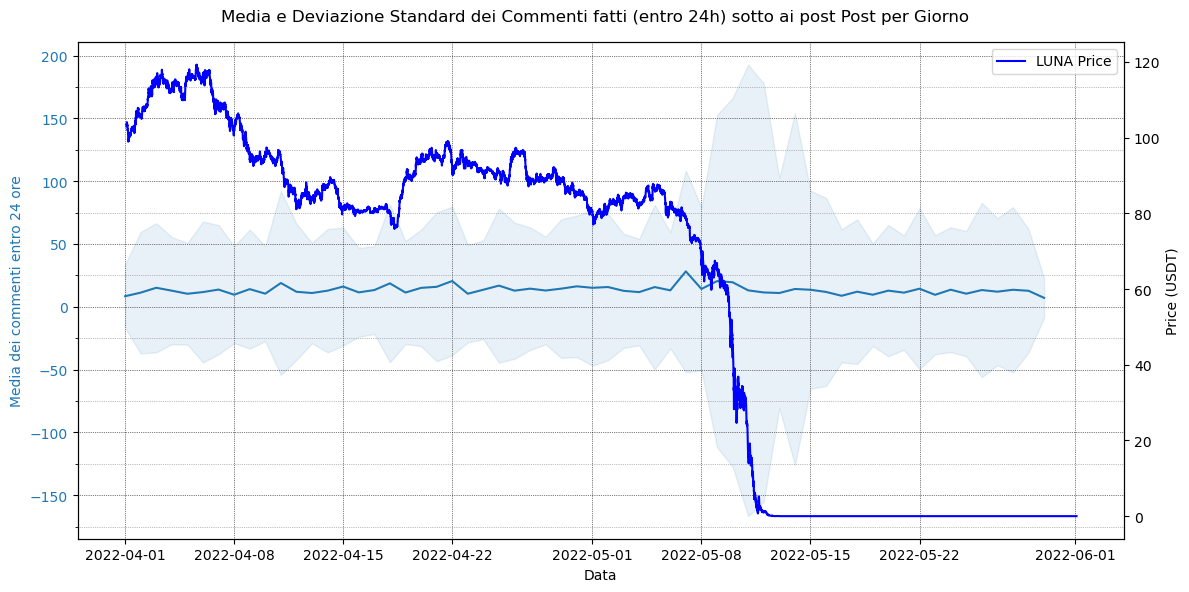

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Supponiamo che il dataframe risultante sia chiamato 'result'
# Creiamo la colonna 'comments_24h_total'
result['comments_24h_total'] = result[['comments_1h', 'comments_6h', 'comments_24h']].sum(axis=1)

# Estraiamo la data dal timestamp 'created_utc' e aggiungiamo una colonna 'date'
result['date'] = result['created_utc'].dt.date

# Filtriamo i dati per includere solo le date a partire dal primo aprile
filtered_result = result[result['created_utc'] >= pd.Timestamp('2022-04-01')]

# Raggruppiamo per giorno e calcoliamo la media, la varianza e la deviazione standard dei commenti entro 24 ore
daily_stats = filtered_result.groupby('date')['comments_24h_total'].agg(['mean', 'var', 'std']).reset_index()

# Rinominiamo le colonne per chiarezza
daily_stats.columns = ['date', 'mean_comments_24h', 'var_comments_24h', 'std_comments_24h']

# Creiamo le colonne per la deviazione standard superiore e inferiore
daily_stats['upper_std'] = daily_stats['mean_comments_24h'] + daily_stats['std_comments_24h']
daily_stats['lower_std'] = daily_stats['mean_comments_24h'] - daily_stats['std_comments_24h']

# Salva il DataFrame combinato in un file CSV (opzionale)
daily_stats.to_csv('mediaDeviazioneComm_Terra.csv')

# Creiamo il grafico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Grafico della media dei commenti per post al giorno
ax1.set_xlabel('Data')
ax1.set_ylabel('Media dei commenti entro 24 ore', color='tab:blue')
ax1.plot(daily_stats['date'], daily_stats['mean_comments_24h'], color='tab:blue', label='Media dei commenti entro 24 ore')
ax1.fill_between(daily_stats['date'], daily_stats['lower_std'], daily_stats['upper_std'], color='tab:blue', alpha=0.1)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plotta il grafico del prezzo di FTT
ax2 = ax1.twinx()
ax2.plot(df_price_nov['open_time'], df_price_nov['open'], label='LUNA Price', color='blue')
ax2.legend(loc='upper right')
ax2.set_ylabel('Price (USDT)')

#ax1.grid(which='both', axis='both', linestyle='--', linewidth=0.5)

# Aggiungere griglia principale
ax1.grid(which='major', linestyle=':', linewidth='0.5', color='black')

# Aggiungere griglia minore
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# Impostare le linee della griglia minore
#ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Più linee verticali minori
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Più linee orizzontali minori

# Aggiungiamo un titolo e le legende
fig.suptitle('Media e Deviazione Standard dei Commenti fatti (entro 24h) sotto ai post Post per Giorno')
fig.tight_layout()  # Per evitare sovrapposizioni di etichette
plt.show()


#### Passo 5: Salvo i primi 1000 post per numero di commenti ricevuti entro il 12/11/2022

In [142]:
# Ordina il DataFrame in base al totale dei commenti in ordine decrescente
result_sorted = result.sort_values(by='total_comments', ascending=False)

# Prendi i top 1000 post con più commenti
top_1000_posts = result_sorted.head(1000)

# Visualizza il risultato
print(top_1000_posts)

           id               author  score  num_comments         created_utc  \
8118   umwhav        AutoModerator    452         25360 2022-05-11 00:00:09   
8862   unvnyw   IHaventEvenGotADog    309         15160 2022-05-12 07:38:40   
10031  up4vhy        AutoModerator    207          9252 2022-05-14 00:00:10   
7814   um52ai        AutoModerator    243          9332 2022-05-10 00:00:08   
7938   umfeus  MediumAdhesiveness5   1107          6496 2022-05-10 10:17:55   
...       ...                  ...    ...           ...                 ...   
933    sy4y4g          StefansLair    989           235 2022-02-21 21:26:07   
5310   tyy24w             gorgos19    197           180 2022-04-08 07:29:52   
6862   uedekh          Mandrake_m2     73           138 2022-04-29 04:00:39   
8063   umrg3i    Socialinfluencing     29            64 2022-05-10 20:06:40   
12850  v0wyjw           kyle_h2486     37           324 2022-05-30 10:10:04   

       comments_1h  comments_6h  comments_24h  comm

Il post con più commenti:
https://www.reddit.com/r/CryptoCurrency/comments/  ?????????????????????

In [143]:
# Salva il DataFrame in un file CSV
top_1000_posts.to_csv('top_1000_posts_Terra.csv', index=False)

# 6 - Analisi del sentiment con Vader

### Prendo solo i post

In [152]:
import pandas as pd
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Funzione per convertire il timestamp in una data leggibile
def convert_timestamp_to_readable_date(timestamp):
    try:
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None

# Funzione per classificare il sentiment
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Carica i dati dei post
posts_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_post_terra2.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
posts_df['created_utc'] = pd.to_numeric(posts_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
posts_df['created_utc'] = posts_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop_p = ['subreddit', 'permalink', 'edited', 'stickied', 'link_flair_text', 'distinguished', 'downs', 'ups']
posts_df.drop(columns=columns_to_drop_p, inplace=True)

# Inizializzare il sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Applicare l'analisi del sentiment sui post (selftext e title)
posts_df['sentiment_selftext'] = posts_df['selftext'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))
posts_df['sentiment_title'] = posts_df['title'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))

# Unire i risultati del sentiment nei post (selftext e title) in un'unica colonna sentiment
posts_df['sentiment'] = posts_df.apply(lambda row: row['sentiment_selftext'] if row['sentiment_selftext'] != 'neutral' else row['sentiment_title'], axis=1)

# Creare i DataFrame con le colonne 'created_utc' e 'sentiment'
posts_sentiment_df = posts_df[['created_utc', 'sentiment']]

# Visualizzare il DataFrame risultante
print(posts_sentiment_df.head())

# Salva il DataFrame risultante
posts_sentiment_df.to_csv("sentiment_analysis_post_terra.csv", index=False)


          created_utc sentiment
0 2022-02-15 01:00:17  positive
1 2022-02-15 01:43:34  positive
2 2022-02-15 01:43:52  positive
3 2022-02-15 02:07:18  positive
4 2022-02-15 02:48:58  positive


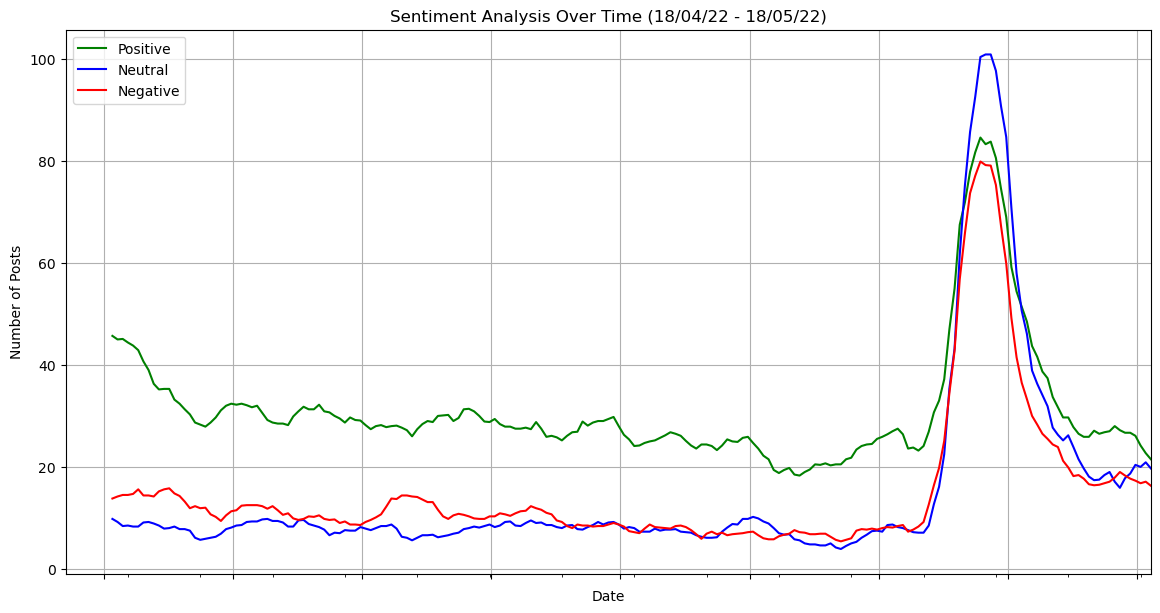

In [155]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_post_terra.csv"
posts_sentiment_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
posts_sentiment_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 30 minuti e conta il numero di occorrenze per ogni sentimento
# resampled_df = combined_df.groupby([pd.Grouper(freq='30T'), 'sentiment']).size().reset_index(name='count')
resampled_df = posts_sentiment_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=10).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=10).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=10).mean()

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati
pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Number of Posts')
ax.set_title('Sentiment Analysis Over Time (18/04/22 - 18/05/22)')
ax.legend(loc='upper left')

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


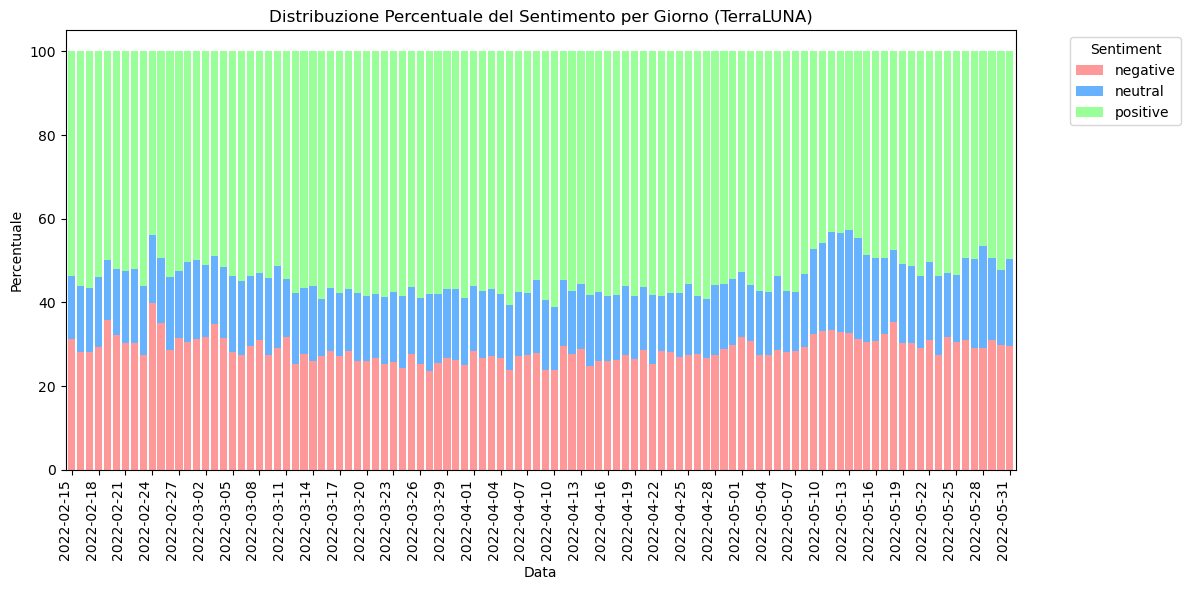

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results_terra.csv"
df = pd.read_csv(file_path)

# Converti la colonna 'created_utc' in formato datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Estrai la data
df['date'] = df['created_utc'].dt.date

# Raggruppa per giorno e per sentimento, poi conta il numero di occorrenze
daily_sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Calcola la percentuale per ogni categoria di sentiment
daily_sentiment_percentages = daily_sentiment_counts.div(daily_sentiment_counts.sum(axis=1), axis=0) * 100

# Salva i risultati in un file CSV
output_file_path = "C:/Users/giaco/ProgettoIngInf/sentimentPercentagesTerra.csv"
daily_sentiment_percentages.to_csv(output_file_path, index=True, header=True)

# Specifica i colori desiderati
colors = ['#FF9999', '#66B2FF', '#99FF99']  # Rosso, Blu, Verde

# Creazione del barplot cumulato con colori personalizzati
ax = daily_sentiment_percentages.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors, width=0.8)

# Mostra una data ogni 3
dates = daily_sentiment_percentages.index
ax.set_xticks(range(0, len(dates), 3))
ax.set_xticklabels([dates[i] for i in range(0, len(dates), 3)], rotation=90, ha='right')

plt.title('Distribuzione Percentuale del Sentimento per Giorno (TerraLUNA)')
plt.xlabel('Data')
plt.ylabel('Percentuale')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


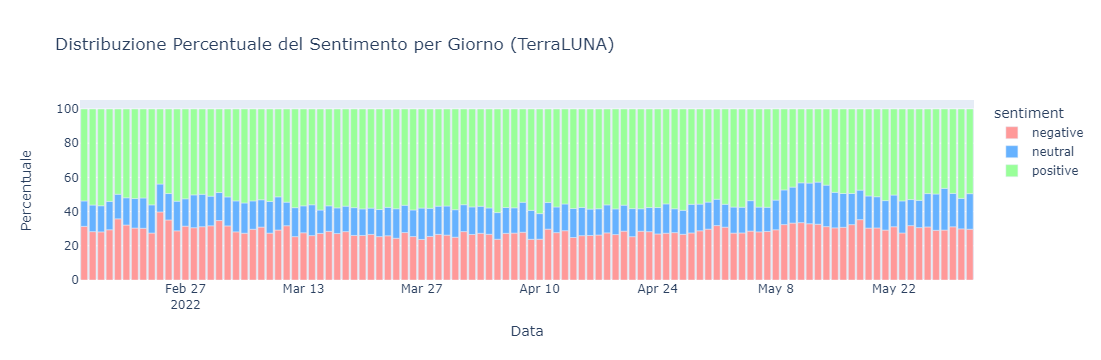

In [20]:
import pandas as pd
import plotly.express as px

# Converti la colonna 'created_utc' in formato datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Estrai la data
df['date'] = df['created_utc'].dt.date

# Raggruppa per giorno e per sentimento, poi conta il numero di occorrenze
daily_sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Calcola la percentuale per ogni categoria di sentiment
daily_sentiment_percentages = daily_sentiment_counts.div(daily_sentiment_counts.sum(axis=1), axis=0) * 100

# Converte il DataFrame in un formato adatto per Plotly
daily_sentiment_percentages.reset_index(inplace=True)
melted_df = daily_sentiment_percentages.melt(id_vars='date', value_vars=['negative', 'neutral', 'positive'], 
                                             var_name='sentiment', value_name='percentage')

# Creazione del barplot cumulato interattivo con Plotly
fig = px.bar(melted_df, x='date', y='percentage', color='sentiment', 
             title='Distribuzione Percentuale del Sentimento per Giorno (TerraLUNA)',
             labels={'percentage': 'Percentuale', 'date': 'Data'},
             color_discrete_map={'negative': '#FF9999', 'neutral': '#66B2FF', 'positive': '#99FF99'})

# Mostra il grafico
fig.show()

          created_utc  sentiment_score
0 2022-02-15 01:00:17           0.9202
1 2022-02-15 01:43:34           0.9571
2 2022-02-15 01:43:52           0.6486
3 2022-02-15 02:07:18           0.9516
4 2022-02-15 02:48:58           0.9698


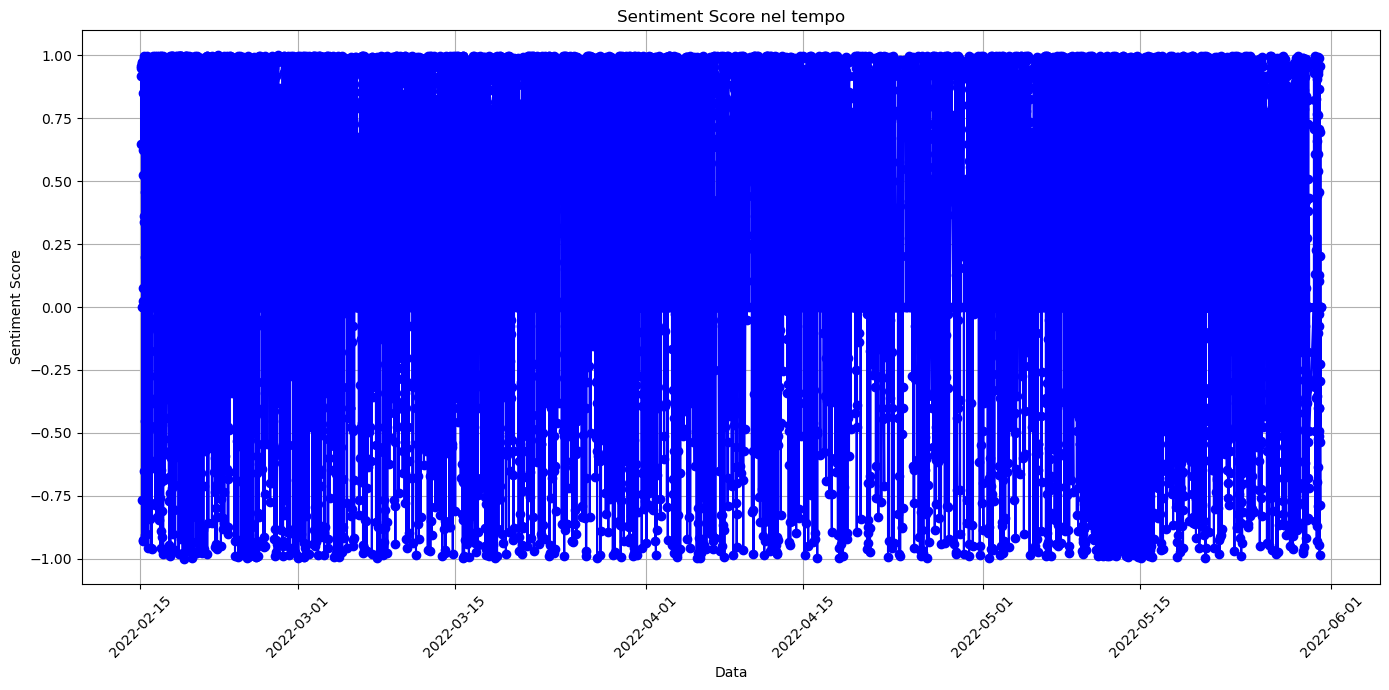

In [159]:
import pandas as pd
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Funzione per convertire il timestamp in una data leggibile
def convert_timestamp_to_readable_date(timestamp):
    try:
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None

# Carica i dati dei post
posts_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_post_terra2.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
posts_df['created_utc'] = pd.to_numeric(posts_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
posts_df['created_utc'] = posts_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop_p = ['subreddit', 'permalink', 'edited', 'stickied', 'link_flair_text', 'distinguished', 'downs', 'ups']
posts_df.drop(columns=columns_to_drop_p, inplace=True)

# Inizializzare il sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Applicare l'analisi del sentiment sui post (selftext e title)
posts_df['sentiment_score_selftext'] = posts_df['selftext'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
posts_df['sentiment_score_title'] = posts_df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Unire i risultati del sentiment nei post (selftext e title) in un'unica colonna sentiment score
posts_df['sentiment_score'] = posts_df.apply(lambda row: row['sentiment_score_selftext'] if row['sentiment_score_selftext'] != 0 else row['sentiment_score_title'], axis=1)

# Creare il DataFrame con le colonne 'created_utc' e 'sentiment_score'
posts_sentiment_df = posts_df[['created_utc', 'sentiment_score']]

# Visualizzare il DataFrame risultante
print(posts_sentiment_df.head())

# Salva il DataFrame risultante
posts_sentiment_df.to_csv("sentiment_analysis_post_terra_score.csv", index=False)

# Plottare il sentiment score nel tempo
plt.figure(figsize=(14, 7))
plt.plot(posts_sentiment_df['created_utc'], posts_sentiment_df['sentiment_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score nel tempo')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


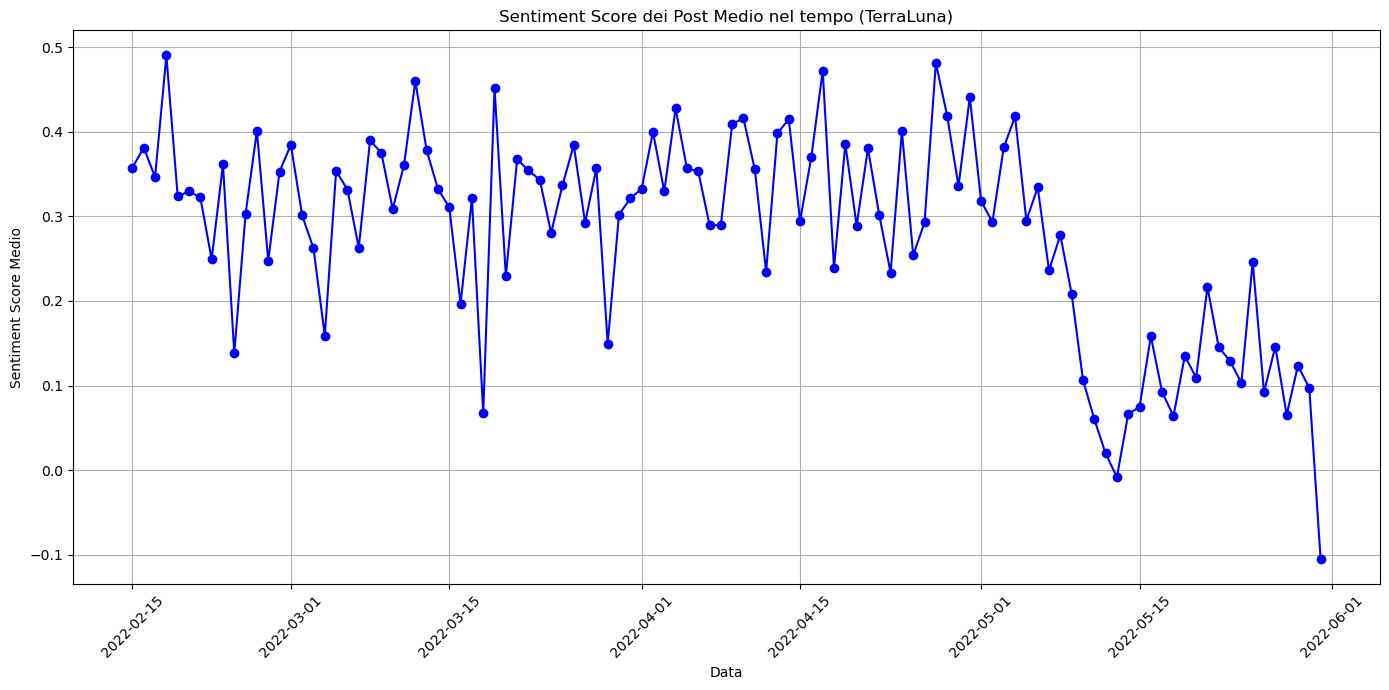

In [183]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il CSV
file_path = 'C:/Users/giaco/ProgettoIngInf/sentiment_analysis_post_terra_score.csv'
df = pd.read_csv(file_path)

# Assicurati che 'created_utc' sia in formato datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Raggruppa per giorno e calcola la media del sentiment score
daily_sentiment = df.set_index('created_utc').resample('D').mean()

# Plotta il sentiment score medio giornaliero
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment.index, daily_sentiment['sentiment_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Sentiment Score Medio')
plt.title('Sentiment Score dei Post Medio nel tempo (TerraLuna)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### Prendo solo i COMMENTI

In [156]:
import pandas as pd
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Funzione per convertire il timestamp in una data leggibile
def convert_timestamp_to_readable_date(timestamp):
    try:
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None

# Funzione per classificare il sentiment
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Carica i dati dei commenti
comments_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_terra2.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
comments_df['created_utc'] = pd.to_numeric(comments_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
comments_df['created_utc'] = comments_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop_c = ['author', 'subreddit', 'author_flair_text', 'author_premium', 'gilded', 'parent_id']
comments_df.drop(columns=columns_to_drop_c, inplace=True)

# Inizializzare il sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Applicare l'analisi del sentiment sui commenti
comments_df['sentiment'] = comments_df['body'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))

# Creare i DataFrame con le colonne 'created_utc' e 'sentiment'
comments_sentiment_df = comments_df[['created_utc', 'sentiment']]

# Visualizzare il DataFrame risultante
print(comments_sentiment_df.head())

# Salva il DataFrame risultante
comments_sentiment_df.to_csv("sentiment_analysis_comments_terra.csv", index=False)


          created_utc sentiment
0 2022-02-15 01:00:10  positive
1 2022-02-15 01:00:40  negative
2 2022-02-15 01:00:51  negative
3 2022-02-15 01:00:56  negative
4 2022-02-15 01:01:39  positive


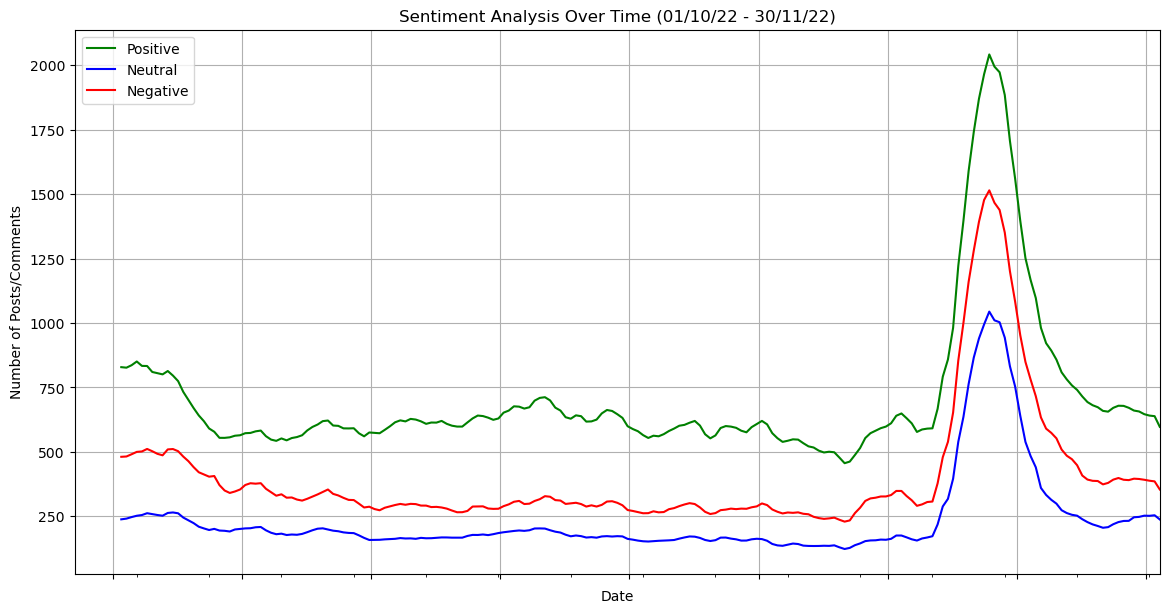

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_comments_terra.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 30 minuti e conta il numero di occorrenze per ogni sentimento
# resampled_df = combined_df.groupby([pd.Grouper(freq='30T'), 'sentiment']).size().reset_index(name='count')
resampled_df = combined_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=10).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=10).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=10).mean()

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati
pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Number of Posts/Comments')
ax.set_title('Sentiment Analysis Over Time (01/10/22 - 30/11/22)')
ax.legend(loc='upper left')

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


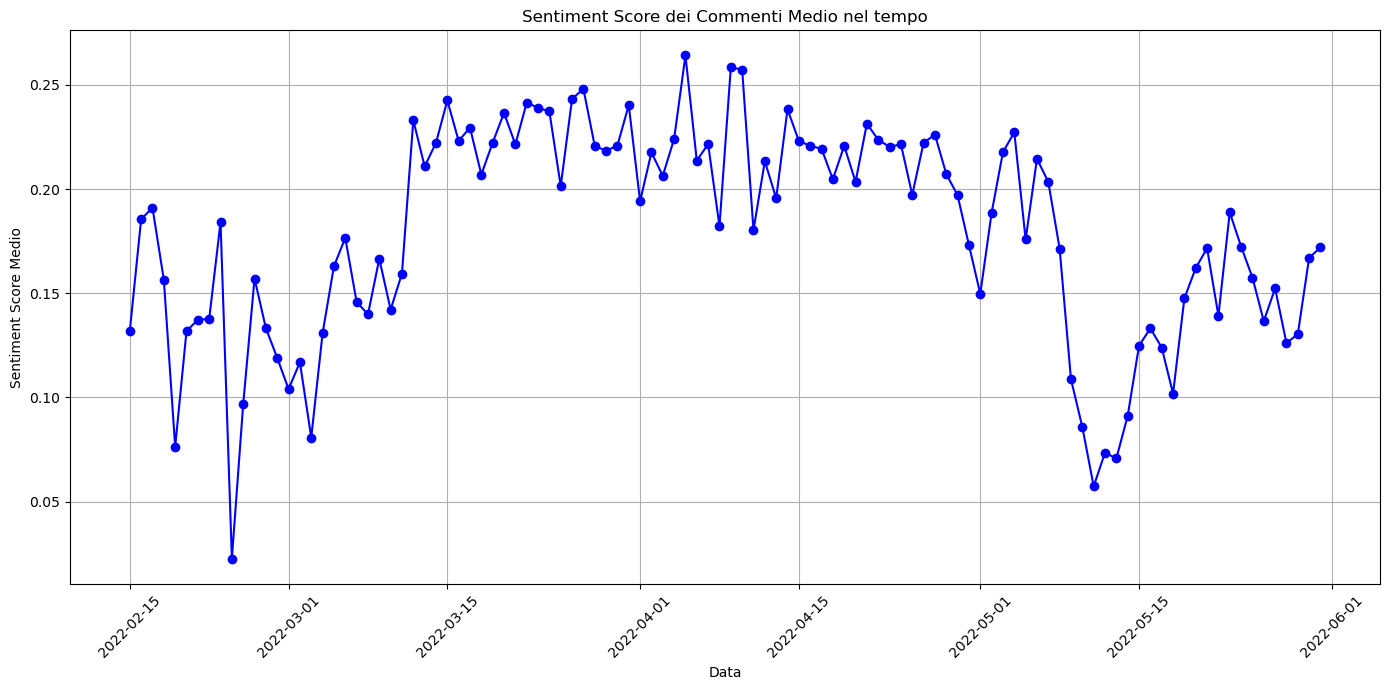

In [182]:
import pandas as pd
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Funzione per convertire il timestamp in una data leggibile
def convert_timestamp_to_readable_date(timestamp):
    try:
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None

# Carica i dati dei commenti
comments_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_terra2.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
comments_df['created_utc'] = pd.to_numeric(comments_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
comments_df['created_utc'] = comments_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop_c = ['author', 'subreddit', 'author_flair_text', 'author_premium', 'gilded', 'parent_id']
comments_df.drop(columns=columns_to_drop_c, inplace=True)

# Inizializzare il sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Applicare l'analisi del sentiment sui commenti
comments_df['sentiment_score'] = comments_df['body'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Creare il DataFrame con le colonne 'created_utc' e 'sentiment_score'
comments_sentiment_df = comments_df[['created_utc', 'sentiment_score']]

# Raggruppa per giorno e calcola la media del sentiment score
daily_sentiment = comments_sentiment_df.set_index('created_utc').resample('D').mean()

# Plotta il sentiment score medio giornaliero
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment.index, daily_sentiment['sentiment_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Sentiment Score Medio')
plt.title('Sentiment Score dei Commenti Medio nel tempo')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Salva il DataFrame risultante
comments_sentiment_df.to_csv("sentiment_analysis_comments_terra_score.csv", index=False)


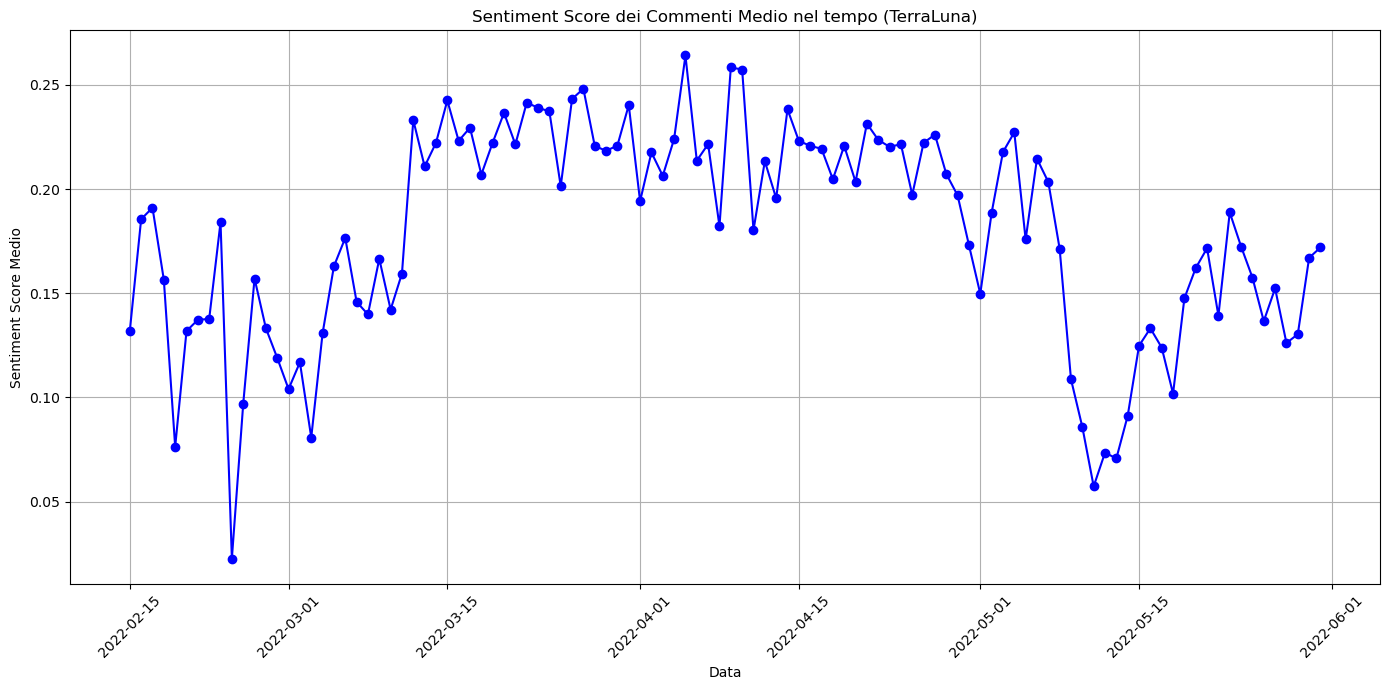

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il CSV
file_path = 'C:/Users/giaco/ProgettoIngInf/sentiment_analysis_comments_terra_score.csv'
df = pd.read_csv(file_path)

# Assicurati che 'created_utc' sia in formato datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Raggruppa per giorno e calcola la media del sentiment score
daily_sentiment = df.set_index('created_utc').resample('D').mean()

# Plotta il sentiment score medio giornaliero
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment.index, daily_sentiment['sentiment_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Sentiment Score Medio')
plt.title('Sentiment Score dei Commenti Medio nel tempo (TerraLuna)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Analisi Commenti e Post insieme

In [144]:
import pandas as pd
from datetime import datetime, timedelta

def convert_timestamp_to_readable_date(timestamp):
    try:
        # Convertire il timestamp in un oggetto datetime
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None  # Gestione degli errori per timestamp non validi

# Carica i dati dei commenti
comments_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_terra2.json", lines=True)
# Carica i dati dei post
posts_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_post_terra2.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
comments_df['created_utc'] = pd.to_numeric(comments_df['created_utc'], errors='coerce')
posts_df['created_utc'] = pd.to_numeric(posts_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
comments_df['created_utc'] = comments_df['created_utc'].apply(convert_timestamp_to_readable_date)
posts_df['created_utc'] = posts_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
# Nei commenti tengo: {"body","created_utc","score","controversiality","link_id"}
columns_to_drop_c = ['author', 'subreddit', 'author_flair_text', 'author_premium', 'gilded', 'parent_id']
comments_df.drop(columns=columns_to_drop_c, inplace=True)
# Nei post tengo: "score","selftext","author","num_comments","created_utc","title","id"
columns_to_drop_p = ['subreddit', 'permalink', 'edited', 'stickied', 'link_flair_text', 'distinguished', 'downs', 'ups']
posts_df.drop(columns=columns_to_drop_p, inplace=True)

# Visualizzare le prime righe del DataFrame risultante
print(comments_df.head())
print(posts_df.head())


                                                body         created_utc  \
0  I encountered a glitch of some kind during reg... 2022-02-15 01:00:10   
1  tldr; The NFL has by far the most crypto-invol... 2022-02-15 01:00:40   
2  tldr; Canadian Prime Minister Justin Trudeau h... 2022-02-15 01:00:51   
3  I just spent $27 on mcdonalds breakfast and co... 2022-02-15 01:00:56   
4  How is something as volatile as BTC going to f... 2022-02-15 01:01:39   

   score  controversiality    link_id  
0     24                 0  t3_ssnwao  
1      1                 0  t3_ssopuy  
2      0                 0  t3_ssnfv6  
3      1                 0  t3_srwqfy  
4      1                 0  t3_srml86  
   score                                           selftext         author  \
0    179  **Welcome to the Daily Discussion. Please read...  AutoModerator   
1      0  Hi guys!\n\nI took about a 9 month break from ...        1097222   
2     12                                                           Bo

-> Controversiality contiene valori 0 o 1:

In [145]:
# Converti la colonna 'controversiality' in tipo intero
comments_df['controversiality'] = comments_df['controversiality'].astype(int)

# Filtra le righe dove 'controversiality' è diverso da 0
comments_df = comments_df[comments_df['controversiality'] != 0]

# Visualizzare le prime righe del DataFrame risultante per verificare
# print(comments_df[['created_utc', 'controversiality']].head())
print(comments_df[comments_df['controversiality'] > 0]['controversiality'])

37        1
43        1
108       1
152       1
190       1
         ..
283812    1
283815    1
283830    1
283858    1
283870    1
Name: controversiality, Length: 8929, dtype: int32


Raccolgo i dati del sentiment in un file csv, dove ho la data con anche l'ora del post/commento e il valore di sentiment (neutro, positivo, negativo) assegnato a quel post:

In [147]:
import pandas as pd
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Funzione per convertire il timestamp in una data leggibile
def convert_timestamp_to_readable_date(timestamp):
    try:
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None

# Funzione per classificare il sentiment
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Carica i dati dei commenti
comments_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_terra2.json", lines=True)
# Carica i dati dei post
posts_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/filtered_post_terra2.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
comments_df['created_utc'] = pd.to_numeric(comments_df['created_utc'], errors='coerce')
posts_df['created_utc'] = pd.to_numeric(posts_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
comments_df['created_utc'] = comments_df['created_utc'].apply(convert_timestamp_to_readable_date)
posts_df['created_utc'] = posts_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop_c = ['author', 'subreddit', 'author_flair_text', 'author_premium', 'gilded', 'parent_id']
comments_df.drop(columns=columns_to_drop_c, inplace=True)
columns_to_drop_p = ['subreddit', 'permalink', 'edited', 'stickied', 'link_flair_text', 'distinguished', 'downs', 'ups']
posts_df.drop(columns=columns_to_drop_p, inplace=True)

# Inizializzare il sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Applicare l'analisi del sentiment sui commenti
comments_df['sentiment'] = comments_df['body'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))

# Applicare l'analisi del sentiment sui post (selftext e title)
posts_df['sentiment_selftext'] = posts_df['selftext'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))
posts_df['sentiment_title'] = posts_df['title'].apply(lambda x: classify_sentiment(analyzer.polarity_scores(x)['compound']))

# Unire i risultati del sentiment nei post (selftext e title) in un'unica colonna sentiment
posts_df['sentiment'] = posts_df.apply(lambda row: row['sentiment_selftext'] if row['sentiment_selftext'] != 'neutral' else row['sentiment_title'], axis=1)

# Creare i DataFrame con le colonne 'created_utc' e 'sentiment'
comments_sentiment_df = comments_df[['created_utc', 'sentiment']]
posts_sentiment_df = posts_df[['created_utc', 'sentiment']]

# Unire i DataFrame dei commenti e dei post
combined_df = pd.concat([comments_sentiment_df, posts_sentiment_df])

# Visualizzare il DataFrame risultante
print(combined_df.head())

# Salva il DataFrame risultante
combined_df.to_csv("sentiment_analysis_results_terra.csv", index=False)


          created_utc sentiment
0 2022-02-15 01:00:10  positive
1 2022-02-15 01:00:40  negative
2 2022-02-15 01:00:51  negative
3 2022-02-15 01:00:56  negative
4 2022-02-15 01:01:39  positive


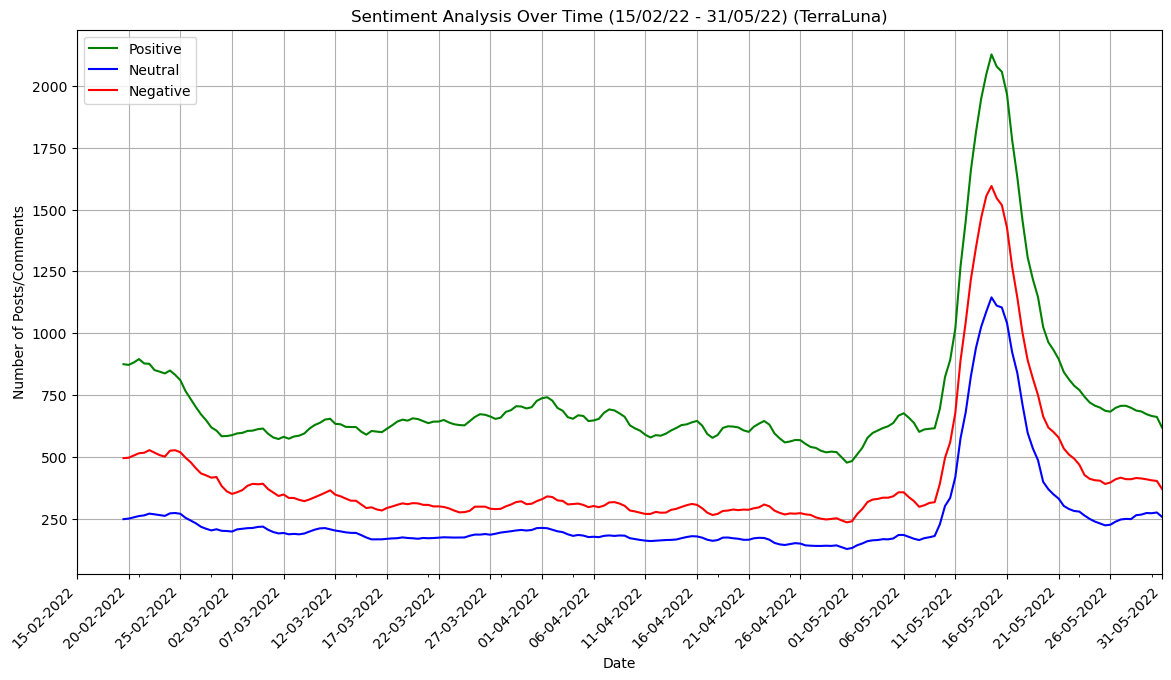

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results_terra.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 30 minuti e conta il numero di occorrenze per ogni sentimento
# resampled_df = combined_df.groupby([pd.Grouper(freq='30T'), 'sentiment']).size().reset_index(name='count')
resampled_df = combined_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=10).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=10).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=10).mean()

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati
pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Number of Posts/Comments')
ax.set_title('Sentiment Analysis Over Time (15/02/22 - 31/05/22) (TerraLuna)')
ax.legend(loc='upper left')

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Personalizza le etichette dell'asse x
date_labels = pd.date_range(start='2022-02-15', end='2022-05-31', freq='5D').strftime('%d-%m-%Y')
ax.set_xticks(pd.date_range(start='2022-02-15', end='2022-05-31', freq='5D'))
ax.set_xticklabels(date_labels)

# Ruota le etichette dell'asse x
plt.xticks(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


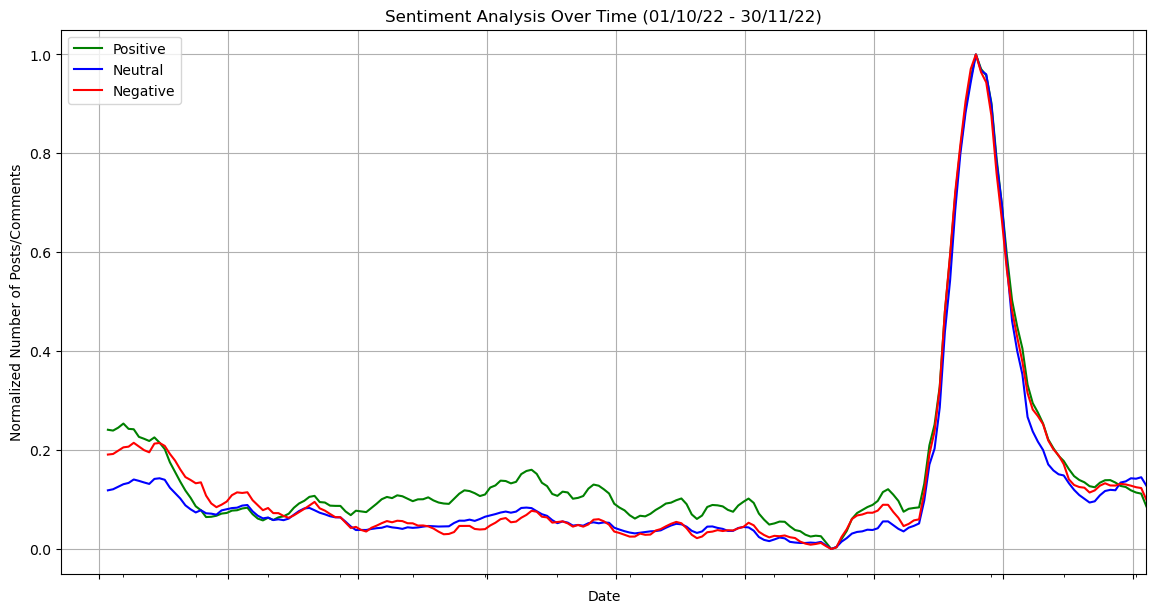

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results_terra.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 30 minuti e conta il numero di occorrenze per ogni sentimento
# resampled_df = combined_df.groupby([pd.Grouper(freq='30T'), 'sentiment']).size().reset_index(name='count')
resampled_df = combined_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=10).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=10).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=10).mean()

# Normalizza i dati
scaler = MinMaxScaler()
pivot_df[['positive', 'neutral', 'negative']] = scaler.fit_transform(pivot_df[['positive', 'neutral', 'negative']])

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments')
ax.set_title('Sentiment Analysis Over Time (01/10/22 - 30/11/22)')
ax.legend(loc='upper left')

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


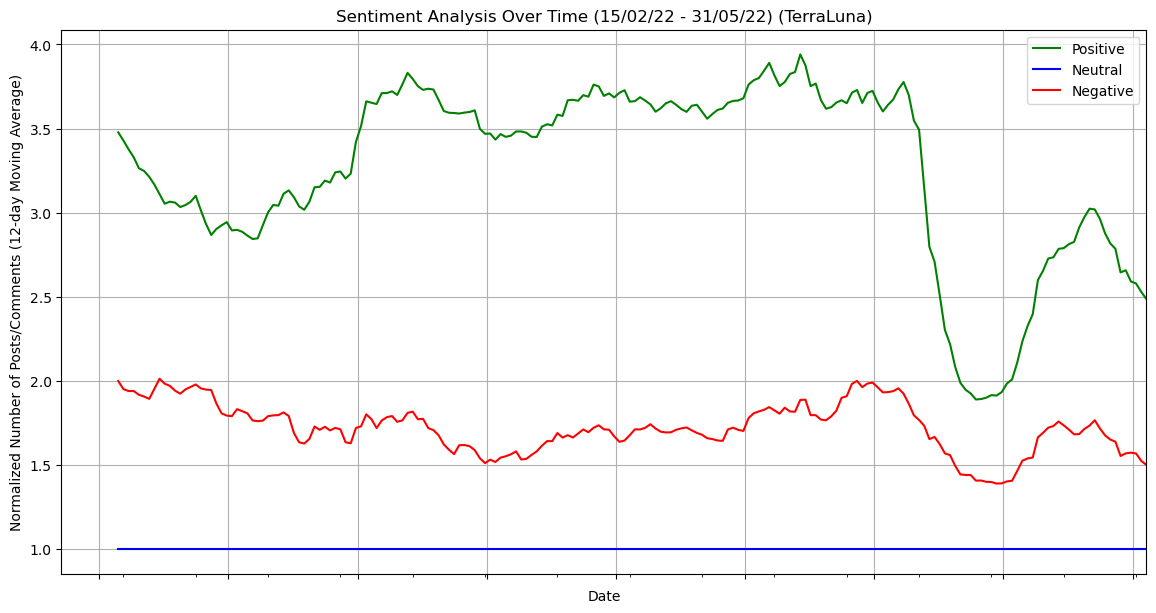

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results_terra.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 30 minuti e conta il numero di occorrenze per ogni sentimento
# resampled_df = combined_df.groupby([pd.Grouper(freq='30T'), 'sentiment']).size().reset_index(name='count')
resampled_df = combined_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=12).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=12).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=12).mean()

# Calcola il massimo valore della linea positiva
max_value = pivot_df['neutral'].max()

# Normalizza le linee neutral e negative usando i valori correnti della linea positiva
pivot_df['negative_normalized'] = (pivot_df['negative'] / pivot_df['neutral'])
pivot_df['positive_normalized'] = (pivot_df['positive'] / pivot_df['neutral'])
#pivot_df['negative_normalized'] = (pivot_df['negative'] / pivot_df['neutral'])/2
#pivot_df['positive_normalized'] = (pivot_df['positive'] / pivot_df['neutral'])/2

# Normalizza anche la linea positiva (dividendo per se stessa)
pivot_df['neutral_normalized'] = (pivot_df['neutral'] / pivot_df['neutral'])
#pivot_df['neutral_normalized'] = (pivot_df['neutral'] / pivot_df['neutral'])/2
#pivot_df['positive_normalized'] = pivot_df['positive'] / max_value

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (12-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (15/02/22 - 31/05/22) (TerraLuna)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


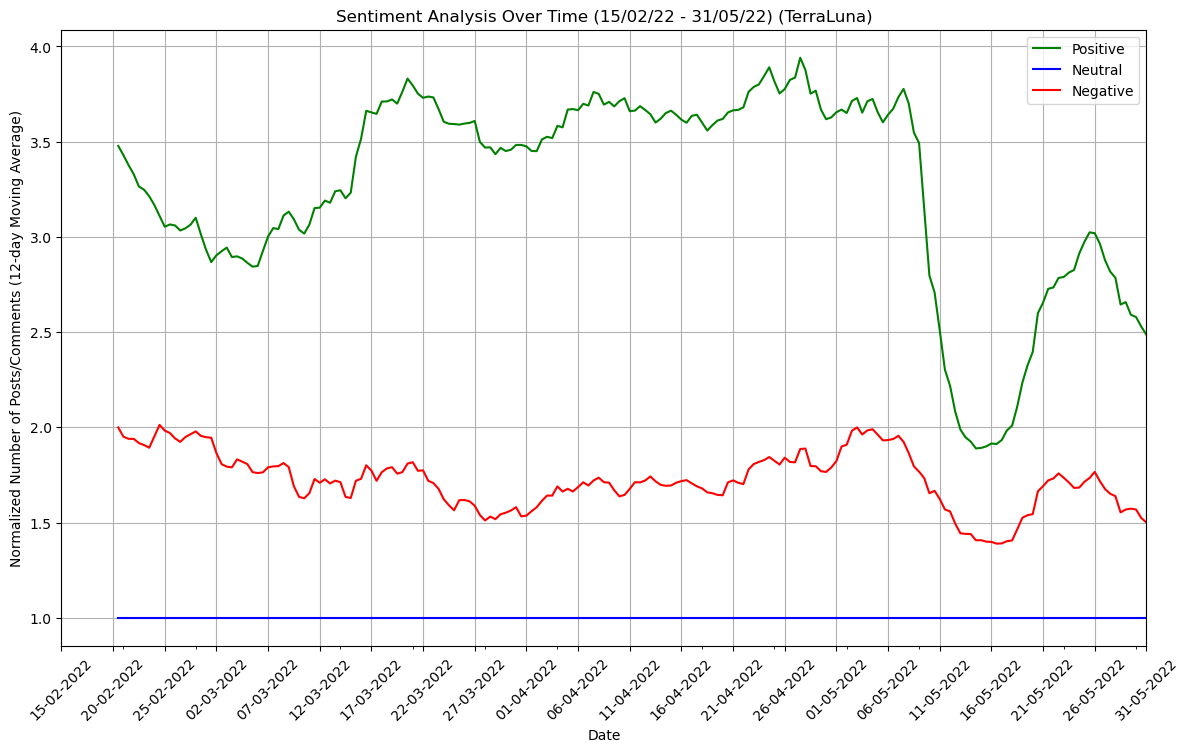

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results_terra.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 12 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=12).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=12).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=12).mean()

# Normalizza le linee usando la linea neutrale
pivot_df['negative_normalized'] = pivot_df['negative'] / pivot_df['neutral']
pivot_df['positive_normalized'] = pivot_df['positive'] / pivot_df['neutral']
pivot_df['neutral_normalized'] = pivot_df['neutral'] / pivot_df['neutral']

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (12-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (15/02/22 - 31/05/22) (TerraLuna)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Personalizza le etichette dell'asse x
date_labels = pd.date_range(start='2022-02-15', end='2022-05-31', freq='5D').strftime('%d-%m-%Y')
ax.set_xticks(pd.date_range(start='2022-02-15', end='2022-05-31', freq='5D'))
ax.set_xticklabels(date_labels)

# Ruota le etichette dell'asse x
plt.xticks(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


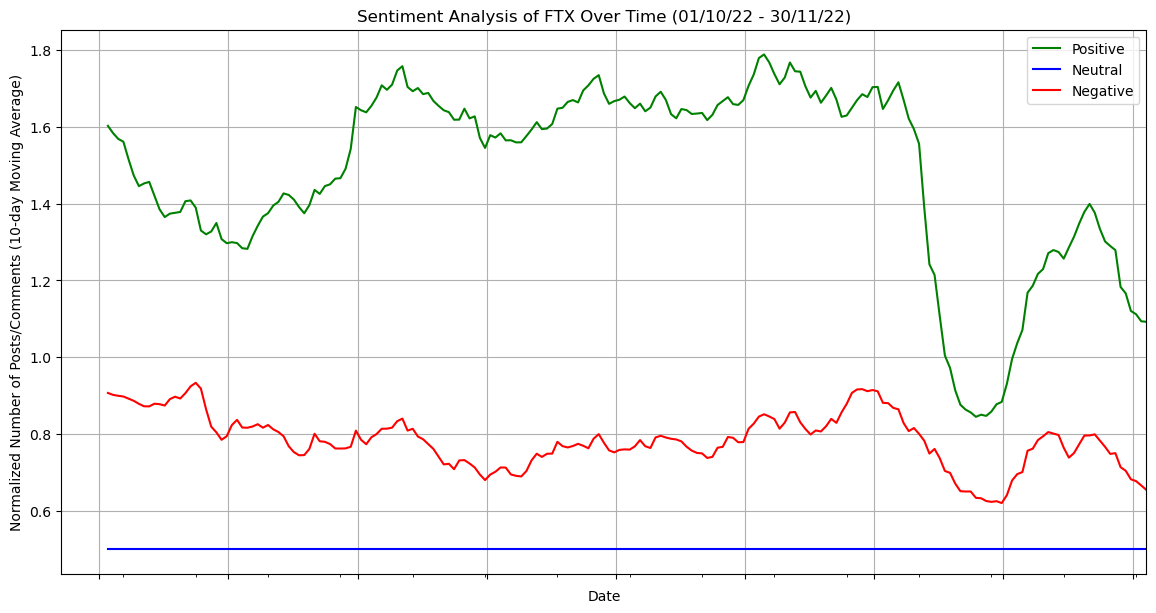

In [151]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_analysis_results_terra.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 30 minuti e conta il numero di occorrenze per ogni sentimento
# resampled_df = combined_df.groupby([pd.Grouper(freq='30T'), 'sentiment']).size().reset_index(name='count')
resampled_df = combined_df.groupby([pd.Grouper(freq='12H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=10).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=10).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=10).mean()

# Calcola il massimo valore della linea positiva
max_value = pivot_df['neutral'].max()

# Normalizza le linee neutral e negative usando i valori correnti della linea positiva
pivot_df['negative_normalized'] = (pivot_df['negative'] / pivot_df['neutral'])/2.2
pivot_df['positive_normalized'] = (pivot_df['positive'] / pivot_df['neutral'])/2.2

# Normalizza anche la linea positiva (dividendo per se stessa)
pivot_df['neutral_normalized'] = (pivot_df['neutral'] / pivot_df['neutral'])/2
#pivot_df['positive_normalized'] = pivot_df['positive'] / max_value

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (10-day Moving Average)')
ax.set_title('Sentiment Analysis of FTX Over Time (01/10/22 - 30/11/22)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


### Comparazione con il sentiment del mercato crypto in un periodo positivo (20/10/20 - 20/02/21)
Un'anailsi del sentiment in un periodo di forte positività nel sentiment di mercato (ad esempio bull run / ath / fomo) e confrontarlo con il grafico di FTX.

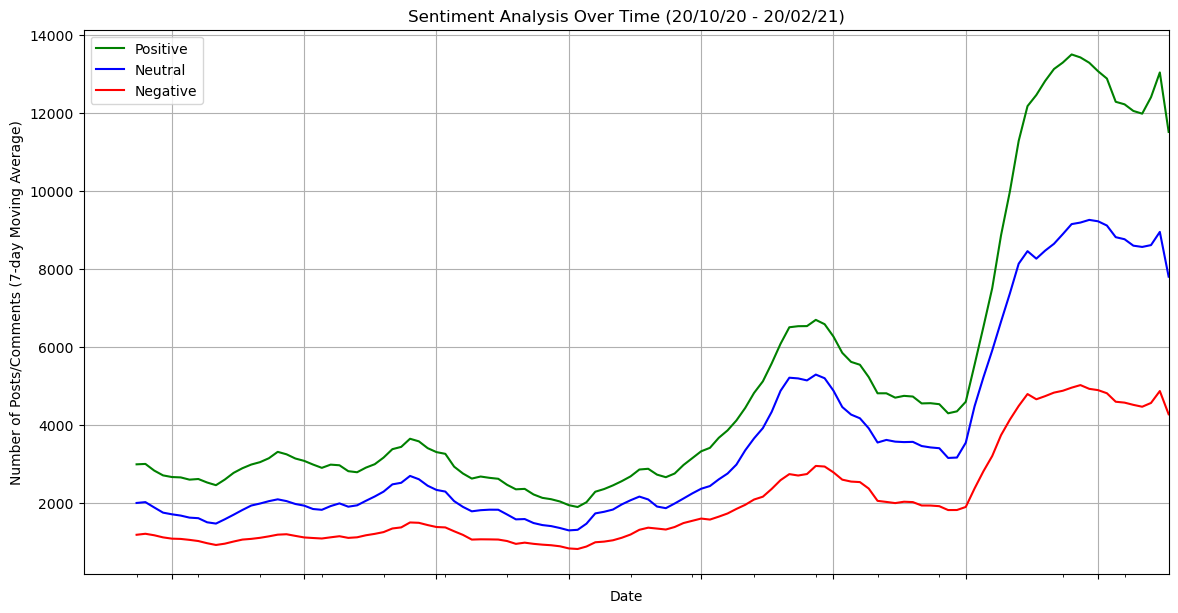

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=7).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=7).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=7).mean()

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati come grafico ad area
# pivot_df.plot.area(ax=ax, alpha=0.5)
# Plotta i dati
#pivot_df['positive'].plot.area(ax=ax, label='Positive', color='green')
#pivot_df['neutral'].plot.area(ax=ax, label='Neutral', color='blue')
#pivot_df['negative'].plot.area(ax=ax, label='Negative', color='red')

pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Number of Posts/Comments (7-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


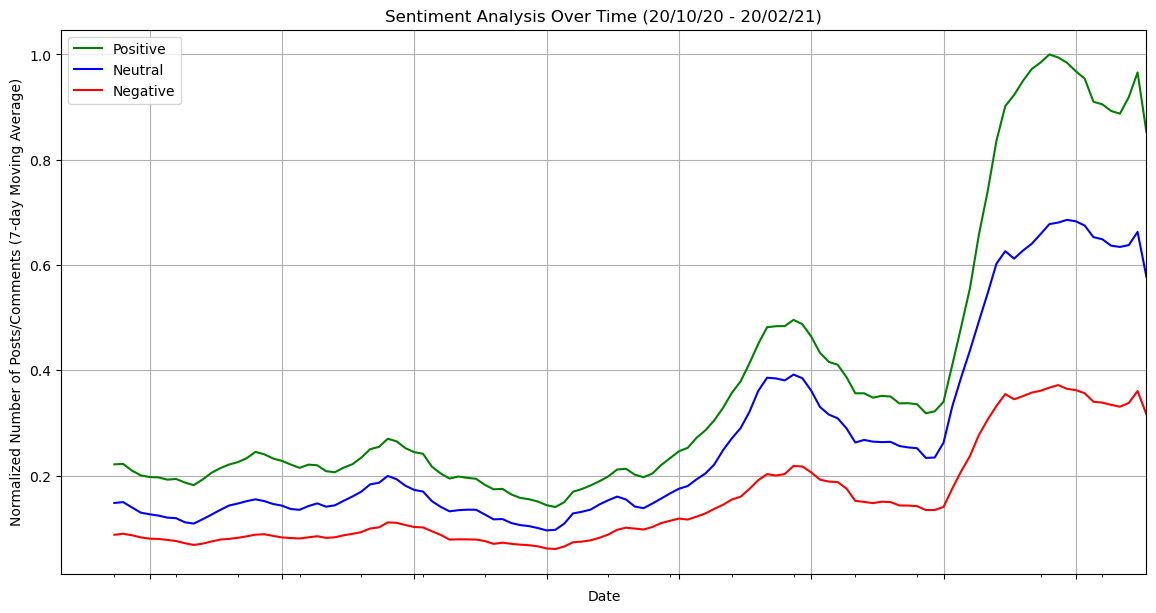

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=7).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=7).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=7).mean()

# Calcola il massimo valore della linea positiva
max_value = pivot_df['positive'].max()

# Normalizza tutte le linee usando il massimo valore della linea positiva
pivot_df['positive'] = pivot_df['positive'] / max_value
pivot_df['neutral'] = pivot_df['neutral'] / max_value
pivot_df['negative'] = pivot_df['negative'] / max_value

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (7-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


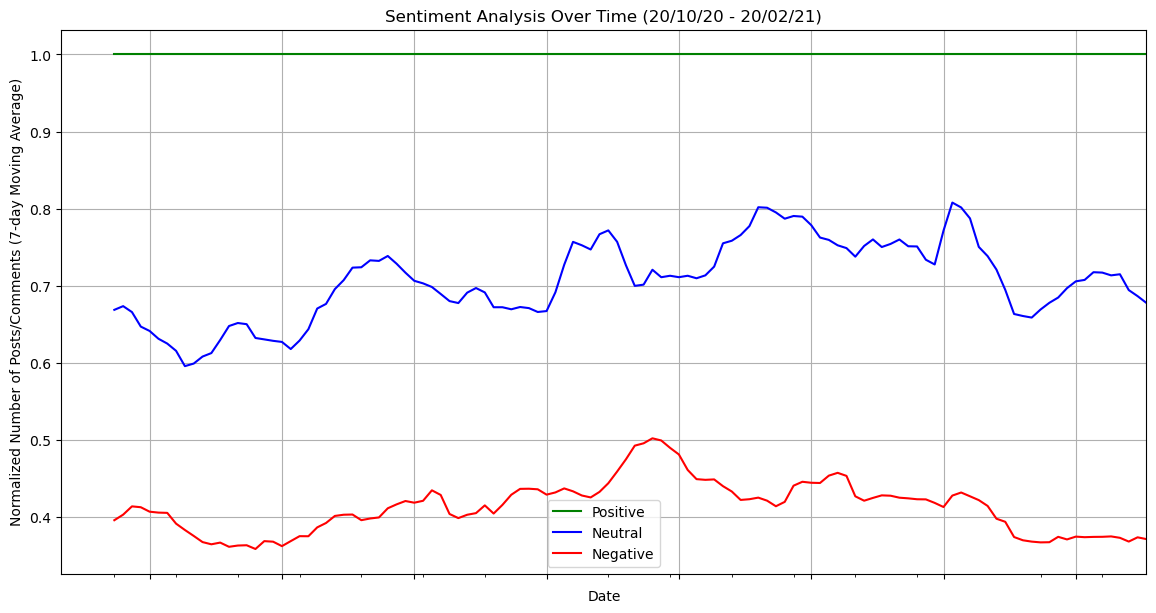

In [150]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=7).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=7).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=7).mean()

# Calcola il massimo valore della linea positiva
max_value = pivot_df['positive'].max()

# Normalizza le linee neutral e negative usando i valori correnti della linea positiva
pivot_df['neutral_normalized'] = pivot_df['neutral'] / pivot_df['positive']
pivot_df['negative_normalized'] = pivot_df['negative'] / pivot_df['positive']

# Normalizza anche la linea positiva (dividendo per se stessa)
pivot_df['positive_normalized'] = pivot_df['positive'] / pivot_df['positive']
#pivot_df['positive_normalized'] = pivot_df['positive'] / max_value

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (7-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


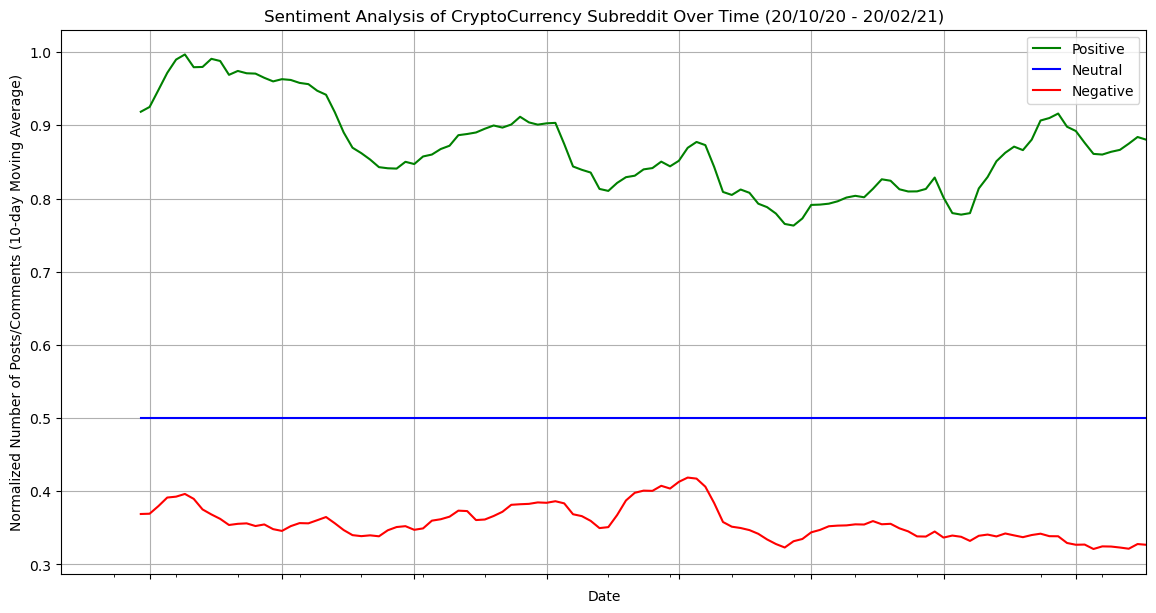

In [182]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=10).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=10).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=10).mean()

# Calcola il massimo valore della linea positiva
max_value = pivot_df['neutral'].max()

# Normalizza le linee neutral e negative usando i valori correnti della linea positiva
pivot_df['negative_normalized'] = (pivot_df['negative'] / pivot_df['neutral'])/1.635
pivot_df['positive_normalized'] = (pivot_df['positive'] / pivot_df['neutral'])/1.635

# Normalizza anche la linea positiva (dividendo per se stessa)
pivot_df['neutral_normalized'] = (pivot_df['neutral'] / pivot_df['neutral'])/2
#pivot_df['positive_normalized'] = pivot_df['positive'] / max_value

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (10-day Moving Average)')
ax.set_title('Sentiment Analysis of CryptoCurrency Subreddit Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


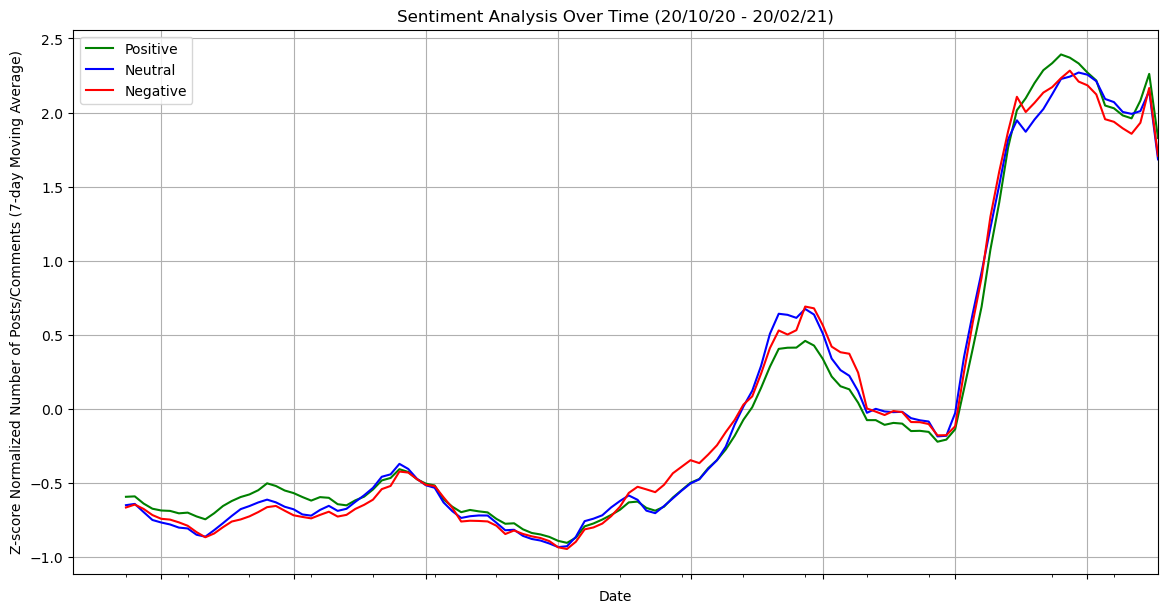

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=7).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=7).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=7).mean()

# Calcola la media e la deviazione standard per ciascuna serie temporale
mean_positive = pivot_df['positive'].mean()
std_positive = pivot_df['positive'].std()

mean_neutral = pivot_df['neutral'].mean()
std_neutral = pivot_df['neutral'].std()

mean_negative = pivot_df['negative'].mean()
std_negative = pivot_df['negative'].std()

# Normalizza i dati usando il metodo z-score
#pivot_df['positive_normalized'] = (pivot_df['positive'] - mean_positive) / std_positive
#pivot_df['neutral_normalized'] = (pivot_df['neutral'] - mean_positive) / std_positive
#pivot_df['negative_normalized'] = (pivot_df['negative'] - mean_positive) / std_positive
pivot_df['positive_normalized'] = (pivot_df['positive'] - mean_positive) / std_positive
pivot_df['neutral_normalized'] = (pivot_df['neutral'] - mean_neutral) / std_neutral
pivot_df['negative_normalized'] = (pivot_df['negative'] - mean_negative) / std_negative

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive_normalized'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral_normalized'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative_normalized'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Z-score Normalized Number of Posts/Comments (7-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


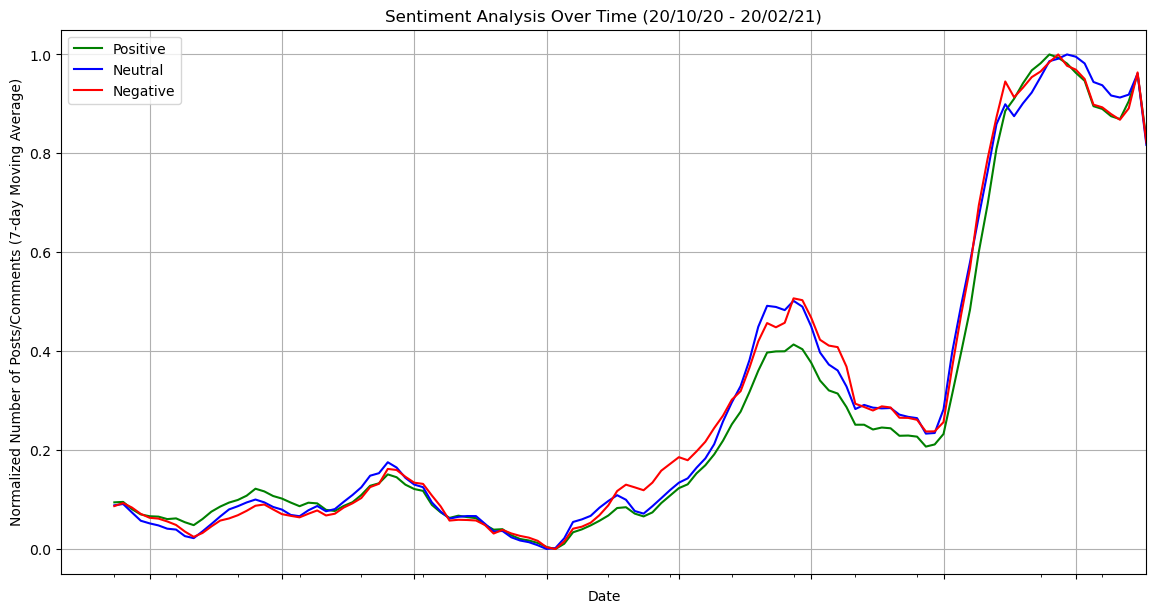

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Carica il DataFrame dal file CSV
file_path = "C:/Users/giaco/ProgettoIngInf/sentiment_btc.csv"
combined_df = pd.read_csv(file_path, parse_dates=['created_utc'])

# Imposta 'created_utc' come indice temporale
combined_df.set_index('created_utc', inplace=True)

# Resample il DataFrame a intervalli di 24 ore e conta il numero di occorrenze per ogni sentimento
resampled_df = combined_df.groupby([pd.Grouper(freq='24H'), 'sentiment']).size().reset_index(name='count')

# Pivot il DataFrame per ottenere le categorie di sentiment come colonne
pivot_df = resampled_df.pivot(index='created_utc', columns='sentiment', values='count').fillna(0)

# Applicare la media mobile per rendere i dati più continui
pivot_df['positive'] = pivot_df['positive'].rolling(window=7).mean()
pivot_df['neutral'] = pivot_df['neutral'].rolling(window=7).mean()
pivot_df['negative'] = pivot_df['negative'].rolling(window=7).mean()

# Normalizza i dati
scaler = MinMaxScaler()
pivot_df[['positive', 'neutral', 'negative']] = scaler.fit_transform(pivot_df[['positive', 'neutral', 'negative']])

# Crea una figura e un asse
fig, ax = plt.subplots(figsize=(14, 8))

# Plotta i dati normalizzati
pivot_df['positive'].plot(ax=ax, label='Positive', color='green')
pivot_df['neutral'].plot(ax=ax, label='Neutral', color='blue')
pivot_df['negative'].plot(ax=ax, label='Negative', color='red')

# Imposta le etichette e il titolo
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Number of Posts/Comments (7-day Moving Average)')
ax.set_title('Sentiment Analysis Over Time (20/10/20 - 20/02/21)')
ax.legend(['Positive', 'Neutral', 'Negative'])

# Formatta l'asse x per mostrare una data ogni 7 giorni
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)

# Mostra la griglia
ax.grid(True)

# Mostra il grafico
plt.show()


          created_utc  sentiment_score
0 2020-10-20 02:03:21           0.0000
1 2020-10-20 02:04:24           0.8316
2 2020-10-20 02:04:55          -0.6310
3 2020-10-20 02:04:58           0.6258
4 2020-10-20 02:06:28           0.0000


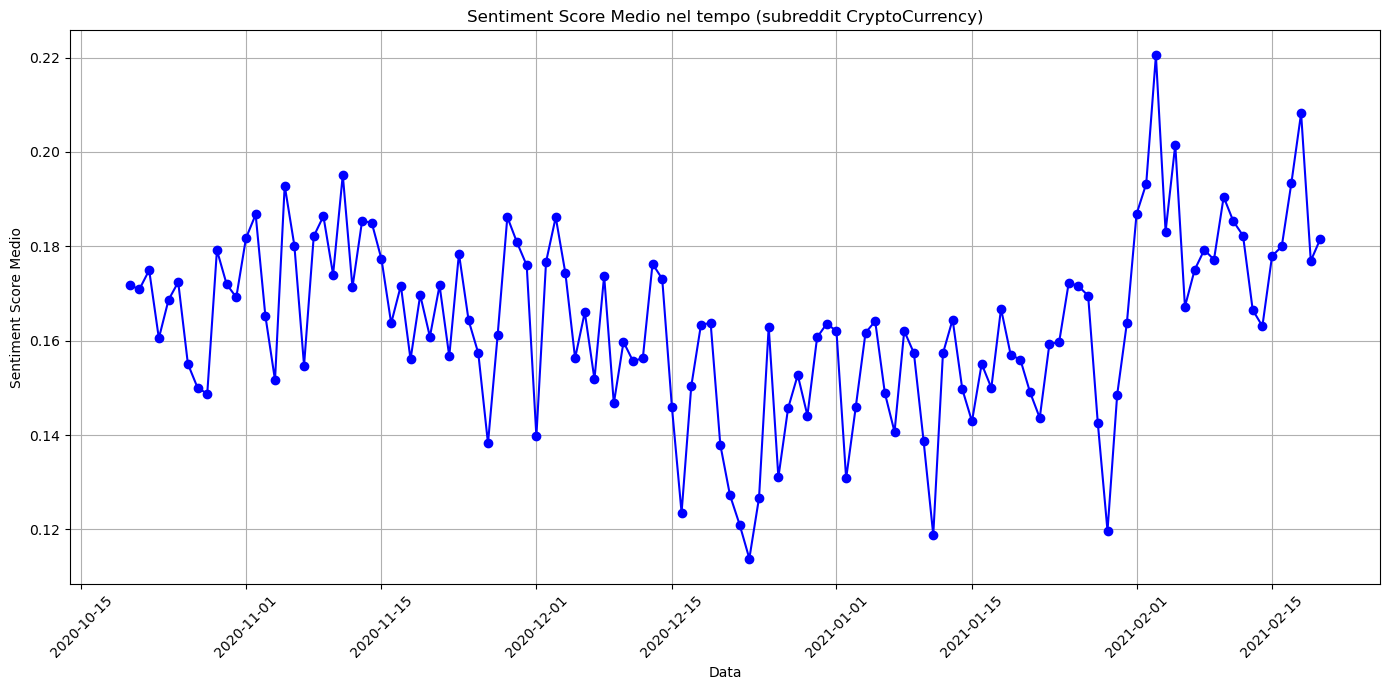

In [188]:
import pandas as pd
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Funzione per convertire il timestamp in una data leggibile
def convert_timestamp_to_readable_date(timestamp):
    try:
        dt_object = datetime.fromtimestamp(int(timestamp) / 1000)
        return dt_object
    except (ValueError, OSError):
        return None

# Carica i dati dei commenti
comments_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/crytpoUpComm.json", lines=True)
# Carica i dati dei post
posts_df = pd.read_json("C:/Users/giaco/ProgettoIngInf/crytpoUpPost.json", lines=True)

# Assicurati che i valori delle colonne created_utc siano numeri interi
comments_df['created_utc'] = pd.to_numeric(comments_df['created_utc'], errors='coerce')
posts_df['created_utc'] = pd.to_numeric(posts_df['created_utc'], errors='coerce')

# Convertire i timestamp nelle colonne "created_utc" in date leggibili
comments_df['created_utc'] = comments_df['created_utc'].apply(convert_timestamp_to_readable_date)
posts_df['created_utc'] = posts_df['created_utc'].apply(convert_timestamp_to_readable_date)

# Eliminare le colonne non necessarie
columns_to_drop_c = ['author', 'subreddit', 'author_flair_text', 'author_premium', 'gilded', 'parent_id']
comments_df.drop(columns=columns_to_drop_c, inplace=True)
columns_to_drop_p = ['subreddit', 'permalink', 'edited', 'stickied', 'link_flair_text', 'distinguished', 'downs', 'ups']
posts_df.drop(columns=columns_to_drop_p, inplace=True)

# Inizializzare il sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Applicare l'analisi del sentiment sui commenti
comments_df['sentiment_score'] = comments_df['body'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Applicare l'analisi del sentiment sui post (selftext e title)
posts_df['sentiment_score_selftext'] = posts_df['selftext'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
posts_df['sentiment_score_title'] = posts_df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Unire i risultati del sentiment nei post (selftext e title) in un'unica colonna sentiment score
posts_df['sentiment_score'] = posts_df.apply(lambda row: row['sentiment_score_selftext'] if row['sentiment_score_selftext'] != 0 else row['sentiment_score_title'], axis=1)

# Creare i DataFrame con le colonne 'created_utc' e 'sentiment_score'
comments_sentiment_df = comments_df[['created_utc', 'sentiment_score']]
posts_sentiment_df = posts_df[['created_utc', 'sentiment_score']]

# Unire i DataFrame dei commenti e dei post
combined_df = pd.concat([comments_sentiment_df, posts_sentiment_df])

# Visualizzare il DataFrame risultante
print(combined_df.head())

# Salva il DataFrame risultante
combined_df.to_csv("sentiment_cryptoUp_score.csv", index=False)

# Raggruppa per giorno e calcola la media del sentiment score
daily_sentiment = combined_df.set_index('created_utc').resample('D').mean()

# Plotta il sentiment score medio giornaliero
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment.index, daily_sentiment['sentiment_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Sentiment Score Medio')
plt.title('Sentiment Score Medio nel tempo (subreddit CryptoCurrency)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Predizione prezzo

## Preparo i dati

### Preparo il csv del **numero di post**

In [57]:
import pandas as pd

# Carica il file CSV
numero_post_df = pd.read_csv('numeroPostTerra.csv')
numero_post_df['date'] = pd.to_datetime(numero_post_df['created_utc']).dt.tz_localize(None)

# Stampa le colonne presenti nel DataFrame
print("Colonne presenti nel DataFrame:", numero_post_df.columns.tolist())

Colonne presenti nel DataFrame: ['created_utc', 'subreddit', 'score', 'selftext', 'permalink', 'author', 'num_comments', 'edited', 'stickied', 'link_flair_text', 'title', 'distinguished', 'id', 'downs', 'ups', 'date']


In [58]:
# Elenco delle colonne da eliminare
columns_to_drop = [
    'created_utc', 'selftext', 'subreddit', 'permalink', 'author', 'edited', 'stickied', 'link_flair_text',
    'title', 'distinguished', 'id', 'downs', 'ups'
]
# Colonne presenti nel DataFrame: ['date', 'score', 'num_comments']

# Elimina le colonne specificate
numero_post_df.drop(columns=columns_to_drop, inplace=True)

# Salva il dataframe modificato in un nuovo file CSV
output_path = 'numeroPostTerra_1.csv'
numero_post_df.to_csv(output_path, index=False)

print(f"Cleaned data saved to '{output_path}'")


Cleaned data saved to 'numeroPostTerra_1.csv'


In [59]:
# Carica il file CSV
file_path = 'numeroPostTerra_1.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Trasforma le date per rimuovere l'ora
df['date'] = df['date'].dt.date

# Aggrega le righe con la stessa data
aggregated_df = df.groupby('date').agg(
    score_mean=('score', 'mean'),
    num_comments_mean=('num_comments', 'mean'),
    num_post=('score', 'size')  # Conta il numero di righe per ogni data
).reset_index()

# Porta la colonna date come prima colonna
cols = ['date'] + [col for col in aggregated_df.columns if col != 'date']
aggregated_df = aggregated_df[cols]

# Salva il dataframe aggregato in un nuovo file CSV
output_path = 'numeroPostTerra_2.csv'
aggregated_df.to_csv(output_path, index=False)

print(f"Aggregated data saved to '{output_path}'")

Aggregated data saved to 'numeroPostTerra_2.csv'


In [60]:
# Normalizza le colonne score_mean e num_comments_mean e num_post
aggregated_df['score_mean'] = aggregated_df['score_mean'] / aggregated_df['score_mean'].max()
aggregated_df['num_comments_mean'] = aggregated_df['num_comments_mean'] / aggregated_df['num_comments_mean'].max()
aggregated_df['num_post'] = aggregated_df['num_post'] / aggregated_df['num_post'].max()

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'numeroPostTerra_3.csv'
aggregated_df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'numeroPostTerra_3.csv'


Sono pronti nel file **numeroPostTerra_3.csv**

### Preparo il csv del **numero di commenti**

In [53]:
#created_utc,author,body,score,controversiality,subreddit,author_flair_text,author_premium,gilded,link_id,parent_id
import pandas as pd

numero_comm_df = pd.read_csv('numeroCommTerra.csv')
numero_comm_df['date'] = pd.to_datetime(numero_comm_df['created_utc']).dt.tz_localize(None)

# Stampa le colonne presenti nel DataFrame
print("Colonne presenti nel DataFrame:", numero_comm_df.columns.tolist())

Colonne presenti nel DataFrame: ['created_utc', 'author', 'body', 'score', 'controversiality', 'subreddit', 'author_flair_text', 'author_premium', 'gilded', 'link_id', 'parent_id', 'date']


In [54]:
# Elenco delle colonne da eliminare
columns_to_drop = [
    'created_utc', 'author', 'body', 'controversiality', 'subreddit', 'author_flair_text', 'author_premium',
    'gilded', 'link_id', 'parent_id'
]
# Colonne presenti nel DataFrame: ['date', 'score']

# Elimina le colonne specificate
numero_comm_df.drop(columns=columns_to_drop, inplace=True)

# Salva il dataframe modificato in un nuovo file CSV
output_path = 'numeroCommTerra_1.csv'
numero_comm_df.to_csv(output_path, index=False)

print(f"Cleaned data saved to '{output_path}'")

Cleaned data saved to 'numeroCommTerra_1.csv'


In [55]:
# Carica il file CSV
file_path = 'numeroCommTerra_1.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Trasforma le date per rimuovere l'ora
df['date'] = df['date'].dt.date

# Aggrega le righe con la stessa data
aggregated_df = df.groupby('date').agg(
    comm_score_mean=('score', 'mean'),
    num_comm=('score', 'size')  # Conta il numero di righe per ogni data
).reset_index()

# Porta la colonna date come prima colonna
cols = ['date'] + [col for col in aggregated_df.columns if col != 'date']
aggregated_df = aggregated_df[cols]

# Salva il dataframe aggregato in un nuovo file CSV
output_path = 'numeroCommTerra_2.csv'
aggregated_df.to_csv(output_path, index=False)

print(f"Aggregated data saved to '{output_path}'")

Aggregated data saved to 'numeroCommTerra_2.csv'


In [56]:
# Normalizza le colonne comm_score_mean e num_comments_mean
aggregated_df['comm_score_mean'] = aggregated_df['comm_score_mean'] / aggregated_df['comm_score_mean'].max()
aggregated_df['num_comm'] = aggregated_df['num_comm'] / aggregated_df['num_comm'].max()

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'numeroCommTerra_3.csv'
aggregated_df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'numeroCommTerra_3.csv'


Sono pronti nel file **numeroCommTerra_3.csv**

### Preparo il csv di **Google Trends**

In [50]:
import pandas as pd

# Carica il file CSV
file_path = 'trendsTerra_1.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Somma le colonne 'col1' e 'col2' per creare una nuova colonna 'col_sum'
df['TerraLUNA'] = df['TerraformLabs'] + df['terraLuna']

# Elenco delle colonne da eliminare
columns_to_drop = [
    'TerraformLabs', 'terraLuna'
]
# Colonne presenti nel DataFrame: ['date', 'TerraLUNA']

# Elimina le colonne specificate
df.drop(columns=columns_to_drop, inplace=True)

# Salva il dataframe aggregato in un nuovo file CSV
output_path = 'trendsTerra_2.csv'
df.to_csv(output_path, index=False)

print(f"Aggregated data saved to '{output_path}'")

Aggregated data saved to 'trendsTerra_2.csv'


In [51]:
# Carica il file CSV
file_path = 'trendsTerra_2.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Normalizza le colonne score_mean e num_comments_mean e num_post
df['TerraLUNA'] = df['TerraLUNA'] / df['TerraLUNA'].max()

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'trendsTerra_3.csv'
df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'trendsTerra_3.csv'


Sono pronti nel file **trendsTerra_3.csv**

### Preparo il csv di **media e deviazione standard dei commenti**

In [64]:
# date,mean_comments_24h,var_comments_24h,std_comments_24h,upper_std,lower_std
# Carica il file CSV
file_path = 'mediaDeviazioneComm_Terra.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Normalizza le colonne score_mean e num_comments_mean e num_post
df['mean_comments_24h'] = df['mean_comments_24h'] / df['mean_comments_24h'].max()
df['var_comments_24h'] = df['var_comments_24h'] / df['var_comments_24h'].max()
df['std_comments_24h'] = df['std_comments_24h'] / df['std_comments_24h'].max()
df['upper_std'] = df['upper_std'] / df['upper_std'].max()
#df['lower_std'] = (-1)*(df['lower_std'] / df['lower_std'].min())
df['lower_std'] = (df['lower_std'] / df['lower_std'].min())

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'mediaDeviazioneComm_Terra_1.csv'
df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'mediaDeviazioneComm_Terra_1.csv'


Sono pronti nel file **mediaDeviazioneComm_Terra_1.csv**

### Preparo il csv della **percentuale delle tipologie di sentiment su base giornaliera**

In [62]:
# date,negative,neutral,positive
# Carica il file CSV
file_path = 'sentimentPercentagesTerra.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Normalizza le colonne score_mean e num_comments_mean e num_post
df['negative'] = df['negative'] / df['negative'].max()
df['neutral'] = df['neutral'] / df['neutral'].max()
df['positive'] = df['positive'] / df['positive'].max()

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'sentimentPercentagesTerra_1.csv'
df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'sentimentPercentagesTerra_1.csv'


(ho eliminato le date prima del 1 marzo)

Sono pronti nel file **sentimentPercentagesTerra_2.csv**

### Preparo il csv del **prezzo di LUNA**

In [66]:
import pandas as pd
from datetime import datetime

# Carica il file CSV
file_path = 'LUNAUSDT_1d.csv'
df = pd.read_csv(file_path)

# open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore

# Assicurati che la colonna della data sia in formato datetime, interpretando correttamente i nanosecondi
df['date'] = pd.to_datetime(df['open_time'], unit='ms').dt.date


# Elenco delle colonne da eliminare
columns_to_drop = [
    'open_time', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
    'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
]
# Colonne presenti nel DataFrame: ['date', 'open']

# Elimina le colonne specificate
df.drop(columns=columns_to_drop, inplace=True)

# Rinominare la colonna
df.rename(columns={'open': 'price_luna'}, inplace=True)

# Porta la colonna date come prima colonna
cols = ['date'] + [col for col in df.columns if col != 'date']
df = df[cols]

# Salva il dataframe aggregato e normalizzato in un nuovo file CSV
output_path = 'LUNAUSDT_1d_2.csv'
df.to_csv(output_path, index=False)

print(f"Aggregated and normalized data saved to '{output_path}'")

Aggregated and normalized data saved to 'LUNAUSDT_1d_2.csv'


## Unisco i vari data frame

In [67]:
import pandas as pd
import glob

# Percorso ai file CSV
file_paths = glob.glob('csvTerra/*.csv')  # Assicurati che i tuoi CSV siano nella stessa directory dello script

# Lista per memorizzare i dataframe
dataframes = []

# Carica ogni file CSV e aggiungilo alla lista
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Unisci tutti i dataframe sulla colonna 'date'
combined_df = dataframes[0]
for df in dataframes[1:]:
    combined_df = combined_df.merge(df, on='date', how='outer')

# Salva il dataframe combinato in un nuovo file CSV
output_path = 'csvTerra/combined_data_terra.csv'
combined_df.to_csv(output_path, index=False)

print(f"Combined data saved to '{output_path}'")

Combined data saved to 'csvTerra/combined_data_terra.csv'


In [68]:
# Carica il file CSV
file_path = 'csvTerra/combined_data_terra.csv'
df = pd.read_csv(file_path)

# Porta la colonna price_ftx come ultima colonna
cols = [col for col in df.columns if col != 'price_luna'] + ['price_luna']
df = df[cols]

# Salva il dataframe combinato in un nuovo file CSV
output_path = 'csvTerra/combined_data_terra_1.csv'
df.to_csv(output_path, index=False)

print(f"Combined data saved to '{output_path}'")

Combined data saved to 'csvTerra/combined_data_terra_1.csv'


## Creare il modello, addestrarlo e fare predizioni

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Carica il file CSV
file_path = 'csvTerra/combined_data_terra_1.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Seleziona le colonne di interesse per il modello
# Supponiamo che il target sia la colonna 'price_luna'
# E tutte le altre colonne tranne 'date' siano feature
features_normalized = df.drop(columns=['date', 'price_luna'])
target = df['price_luna']

# Dividi i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target, test_size=0.2, random_state=42)

# Creare il modello
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Addestrare il modello
model.fit(X_train, y_train)

# Fare predizioni sul test set
y_pred = model.predict(X_test)

# Valutare il modello
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')

# Fare predizioni sull'intero intervallo di date usato per l'addestramento
y_all_pred = model.predict(features_normalized)

# Aggiungi le predizioni al DataFrame originale
df['price_luna_pred'] = y_all_pred

# Salva il dataframe con le predizioni in un nuovo file CSV
output_path = 'combined_data_terra_with_predictions.csv'
df.to_csv(output_path, index=False)

print(f"Data with predictions saved to '{output_path}'")


Mean Squared Error: 106.94254489664006
R^2: 0.9435246999507483
Data with predictions saved to 'combined_data_terra_with_predictions.csv'


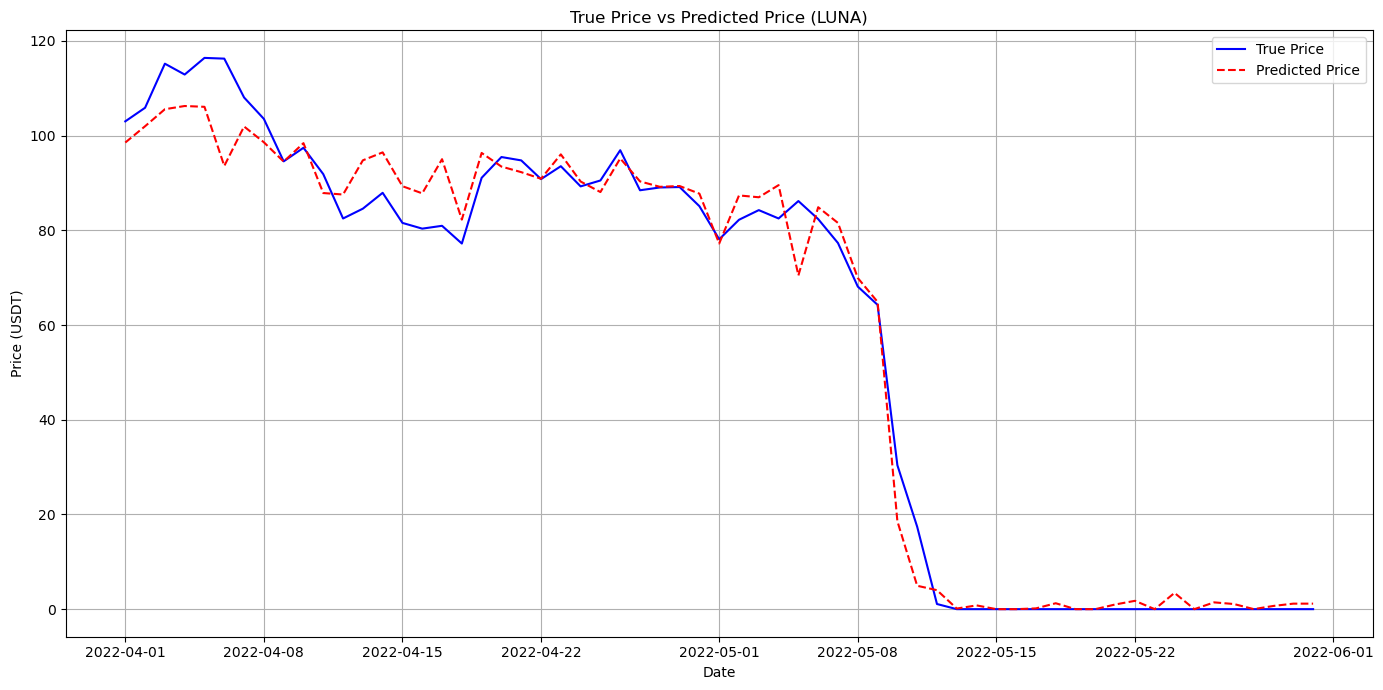

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il file CSV con le predizioni
file_path = 'combined_data_terra_with_predictions.csv'
df = pd.read_csv(file_path)

# Assicurati che la colonna della data sia in formato datetime
df['date'] = pd.to_datetime(df['date'])

# Plotta i grafici del prezzo vero e di quello predetto
plt.figure(figsize=(14, 7))

plt.plot(df['date'], df['price_luna'], label='True Price', color='blue')
plt.plot(df['date'], df['price_luna_pred'], label='Predicted Price', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.title('True Price vs Predicted Price (LUNA)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()